#### Import dependencies

In [1]:
! pip install geopy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import missingno as msno
from scipy.stats import chi2_contingency, f_oneway, jarque_bera, probplot
from utils.data_utils import perform_data_cleaning
from matplotlib.gridspec import GridSpec


#### Loading the data.

In [3]:
# Path to raw data (same folder as this notebook)
RAW_DATA_PATH = "notebooks/swiggy.csv"

# Load raw messy data
raw_df = pd.read_csv(RAW_DATA_PATH)

# Clean the data (save + return cleaned DataFrame)
clean_df = perform_data_cleaning(raw_df, saved_data_path="clean_data.csv")

# Now you can use clean_df for EDA
clean_df.head()

rider_id   age  ratings  restaurant_latitude  restaurant_longitude  \
0   INDORES13DEL02   37.0      4.9            22.745049             75.892471   
1   BANGRES18DEL02   34.0      4.5            12.913041             77.683237   
2   BANGRES19DEL01   23.0      4.4            12.914264             77.678400   
3  COIMBRES13DEL02   38.0      4.7            11.003669             76.976494   
4   CHENRES12DEL01   32.0      4.6            12.972793             80.249982   

   delivery_latitude  delivery_longitude order_date     weather traffic  ...  \
0          22.765049           75.912471 2022-03-19       sunny    high  ...   
1          13.043041           77.813237 2022-03-25      stormy     jam  ...   
2          12.924264           77.688400 2022-03-19  sandstorms     low  ...   
3          11.053669           77.026494 2022-04-05       sunny  medium  ...   
4          13.012793           80.289982 2022-03-26      cloudy    high  ...   

   extracted_city order_day order_month  order_day_of_week order_is_weekend  \
0            INDO        19           3           Saturday                1   
1            BANG        25           3             Friday                0   
2            BANG        19           3           Saturday                1   
3           COIMB         5           4            Tuesday                0   
4            CHEN        26           3           Saturday                1   

  pickup_time_minutes  order_time_hour time_of_day  distance_km  distance_type  
0                15.0             11.0     morning     3.020737          short  
1                 5.0             19.0     evening    20.143737      very_long  
2                15.0              8.0     morning     1.549693          short  
3                10.0             18.0     evening     7.774497         medium  
4                15.0             13.0   afternoon     6.197898         medium  

[5 rows x 27 columns]

#### Cleaning the data using utils file.

#### Preliminary Analysis

In [4]:
# check for missing values in the data
clean_df.isnull().sum()

rider_id                   0
age                     1854
ratings                 1908
restaurant_latitude     3630
restaurant_longitude    3630
delivery_latitude       3630
delivery_longitude      3630
order_date                 0
weather                  525
traffic                  510
vehicle_condition          0
type_of_order              0
type_of_vehicle            0
multiple_deliveries      993
festival                 228
city_type               1198
time_taken                 0
extracted_city             0
order_day                  0
order_month                0
order_day_of_week          0
order_is_weekend           0
pickup_time_minutes     1640
order_time_hour         1640
time_of_day             2070
distance_km             3630
distance_type           3630
dtype: int64

In [5]:
# number of rows in the data that have missing values

missing_rows = (
    clean_df
    .isnull()
    .any(axis=1)
    .sum()
)

print(f'There are {missing_rows} rows with missing values in the data.')

print(f"It accounts for {(missing_rows/clean_df.shape[0])*100:.2f}% of the data")

There are 7807 rows with missing values in the data.
It accounts for 17.16% of the data


In [6]:
# check for duplicate rows in the data

clean_df.duplicated().sum()

np.int64(0)

In [7]:
# data types of features

clean_df.dtypes

rider_id                        object
age                            float64
ratings                        float64
restaurant_latitude            float64
restaurant_longitude           float64
delivery_latitude              float64
delivery_longitude             float64
order_date              datetime64[ns]
weather                         object
traffic                         object
vehicle_condition                int64
type_of_order                   object
type_of_vehicle                 object
multiple_deliveries            float64
festival                        object
city_type                       object
time_taken                       int64
extracted_city                  object
order_day                        int32
order_month                      int32
order_day_of_week               object
order_is_weekend                 int64
pickup_time_minutes            float64
order_time_hour                float64
time_of_day                   category
distance_km              

In [8]:
num_cols = clean_df.columns[[1,2,3,4,5,6,16,22,25]].tolist()
cat_cols = [col for col in clean_df.columns.tolist() if col not in num_cols]

print(f'There are {len(num_cols)} numerical columns and {len(cat_cols)} categorical columns in the data.')

There are 9 numerical columns and 18 categorical columns in the data.


In [9]:
num_cols

['age',
 'ratings',
 'restaurant_latitude',
 'restaurant_longitude',
 'delivery_latitude',
 'delivery_longitude',
 'time_taken',
 'pickup_time_minutes',
 'distance_km']

In [10]:
cat_cols

['rider_id',
 'order_date',
 'weather',
 'traffic',
 'vehicle_condition',
 'type_of_order',
 'type_of_vehicle',
 'multiple_deliveries',
 'festival',
 'city_type',
 'extracted_city',
 'order_day',
 'order_month',
 'order_day_of_week',
 'order_is_weekend',
 'order_time_hour',
 'time_of_day',
 'distance_type']

In [11]:
# statistical summary of numerical columns

clean_df[num_cols].describe()

age       ratings  restaurant_latitude  restaurant_longitude  \
count  43648.000000  43594.000000         41872.000000          41872.000000   
mean      29.555008      4.635287            18.913696             76.921664   
std        5.761482      0.313827             5.467265              3.503107   
min       20.000000      2.500000             9.957144             72.768726   
25%       25.000000      4.500000            12.986047             73.897902   
50%       30.000000      4.700000            19.065838             76.618203   
75%       35.000000      4.900000            22.751234             78.368855   
max       39.000000      5.000000            30.914057             88.433452   

       delivery_latitude  delivery_longitude    time_taken  \
count       41872.000000        41872.000000  45502.000000   
mean           18.977356           76.985325     26.297591   
std             5.469056            3.503260      9.386419   
min             9.967144           72.778726     10.000000   
25%            13.065996           73.940327     19.000000   
50%            19.124049           76.662620     26.000000   
75%            22.820040           78.405467     32.000000   
max            31.054057           88.563452     54.000000   

       pickup_time_minutes   distance_km  
count         43862.000000  41872.000000  
mean              9.989399      9.703311  
std               4.087516      5.593802  
min               5.000000      1.463837  
25%               5.000000      4.648474  
50%              10.000000      9.177288  
75%              15.000000     13.659637  
max              15.000000     20.942906

In [12]:
for cols in cat_cols:
    clean_df[cols] = clean_df[cols].astype('object')

summary = clean_df.describe(include='object').T
summary


C:\Users\Nikhil Bhardwaj\AppData\Local\Temp\ipykernel_3484\1670903078.py:4: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  summary = clean_df.describe(include='object').T


count unique                  top     freq
rider_id               45502   1320      PUNERES01DEL01        67
order_date             45502     44  2022-03-15 00:00:00     1190
weather                44977      6                  fog     7654
traffic                44992      4                  low    15477
vehicle_condition      45502      4                    2    15034
type_of_order          45502      4                snack    11512
type_of_vehicle        45502      4           motorcycle    26427
multiple_deliveries  44509.0    4.0                  1.0  28109.0
festival               45274      2                   no    44380
city_type              44304      3        metropolitian    34029
extracted_city         45502     22                  JAP     3439
order_day              45502     30                    3     2323
order_month            45502      3                    3    31919
order_day_of_week      45502      7            Wednesday     7077
order_is_weekend       45502      2                    0    32995
order_time_hour      43862.0   17.0                 21.0   4686.0
time_of_day            43432      4                night    13773
distance_type          41872      4               medium    11288

<Axes: >

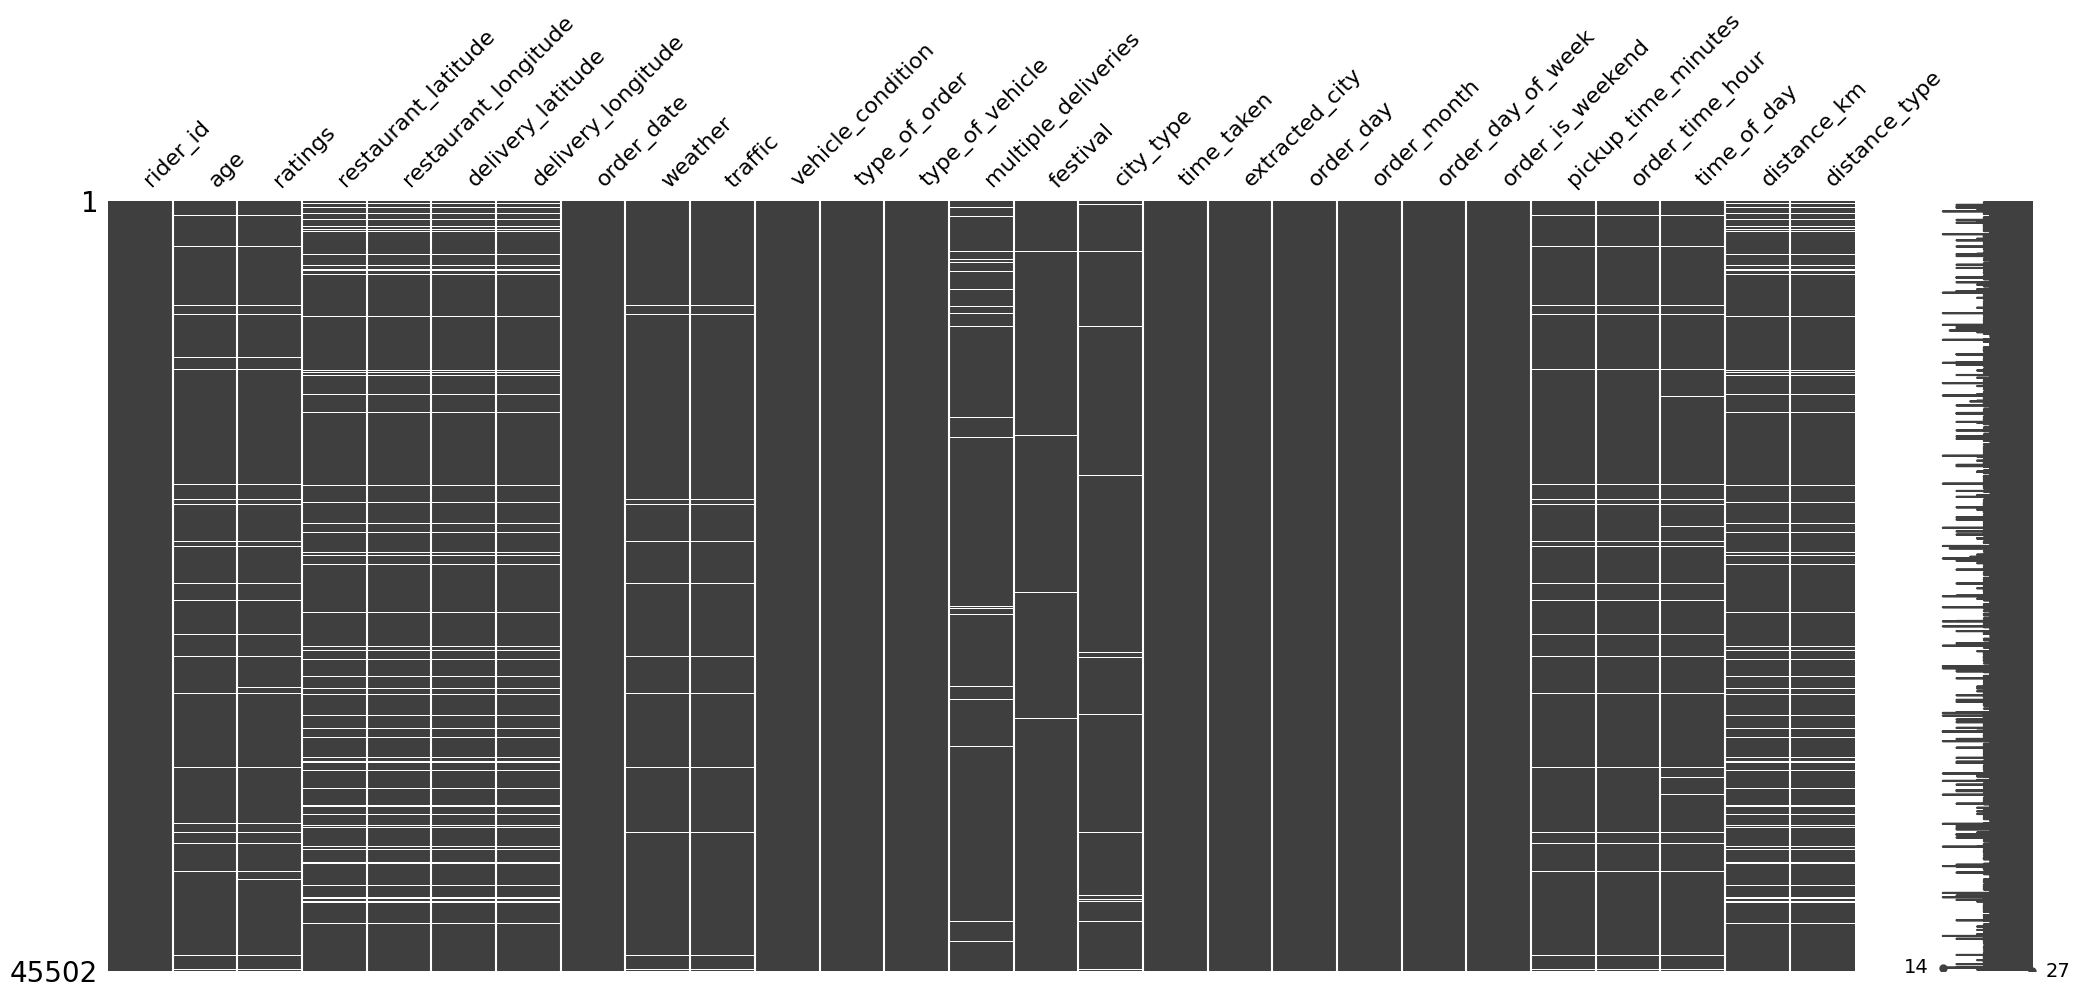

In [13]:
msno.matrix(clean_df)

<Axes: >

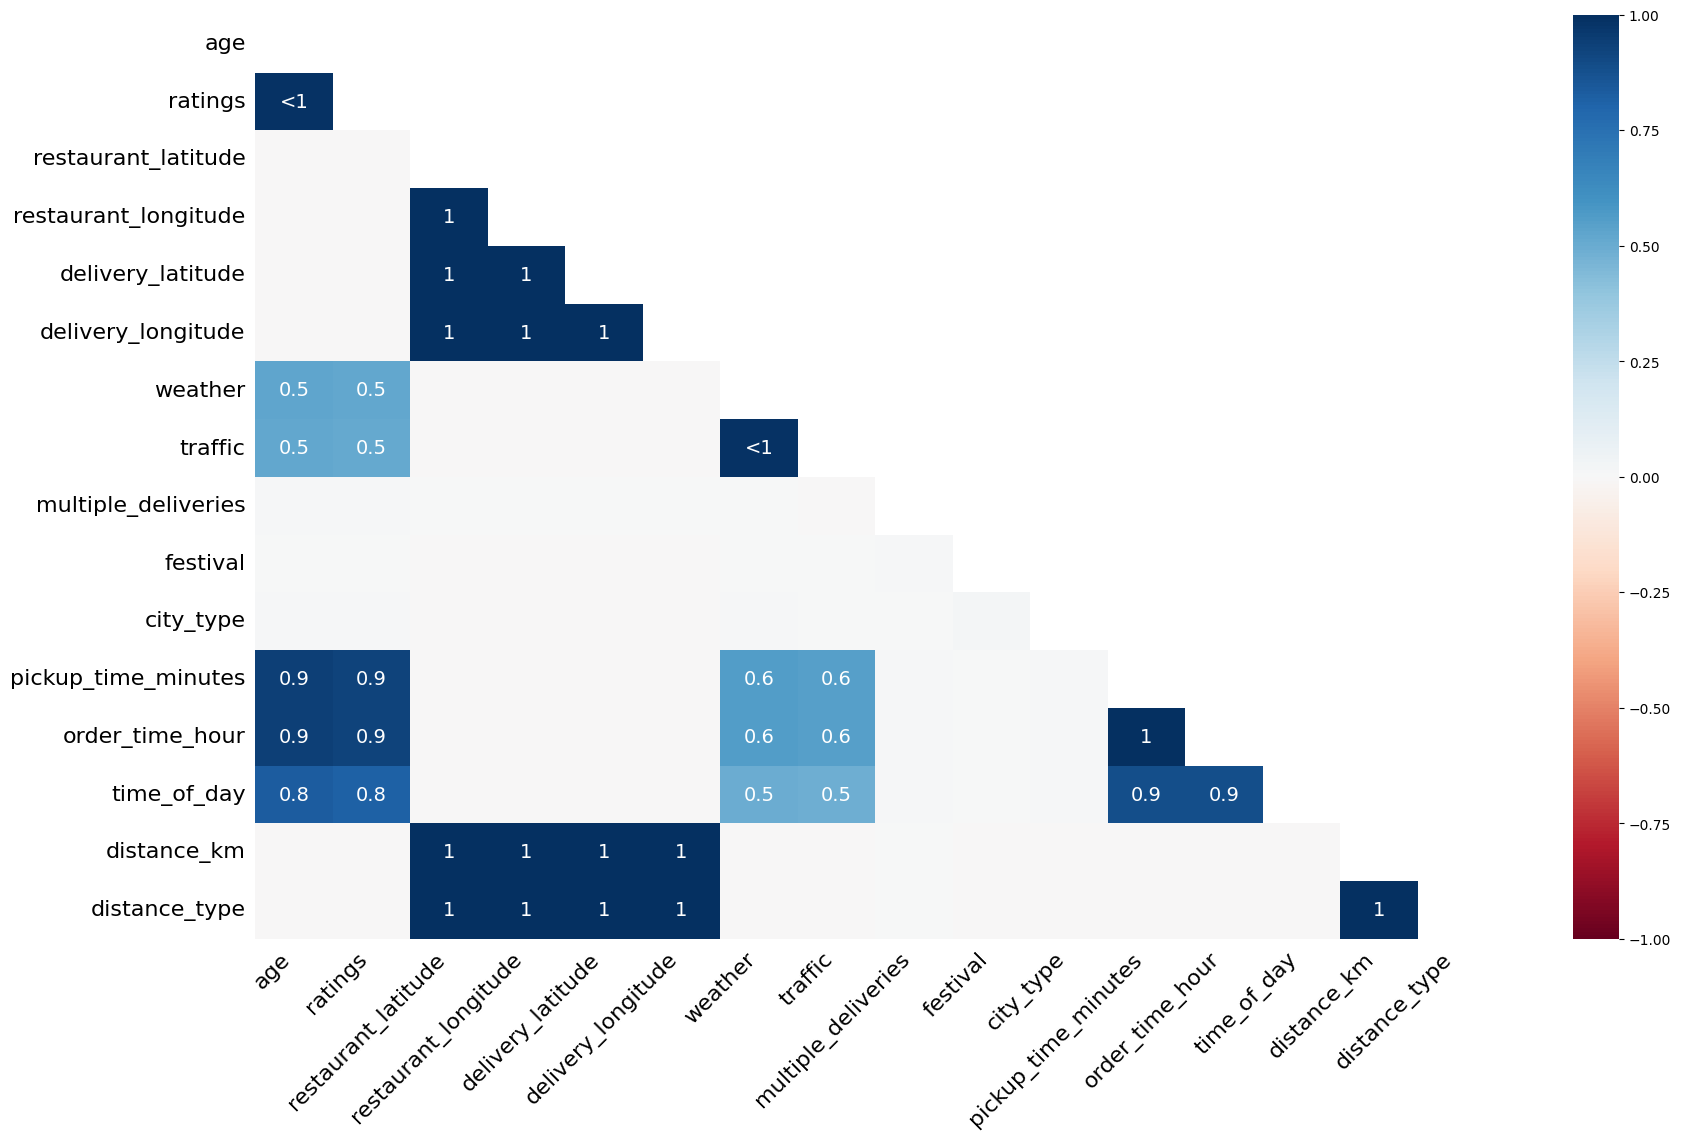

In [14]:
msno.heatmap(clean_df)

<Axes: >

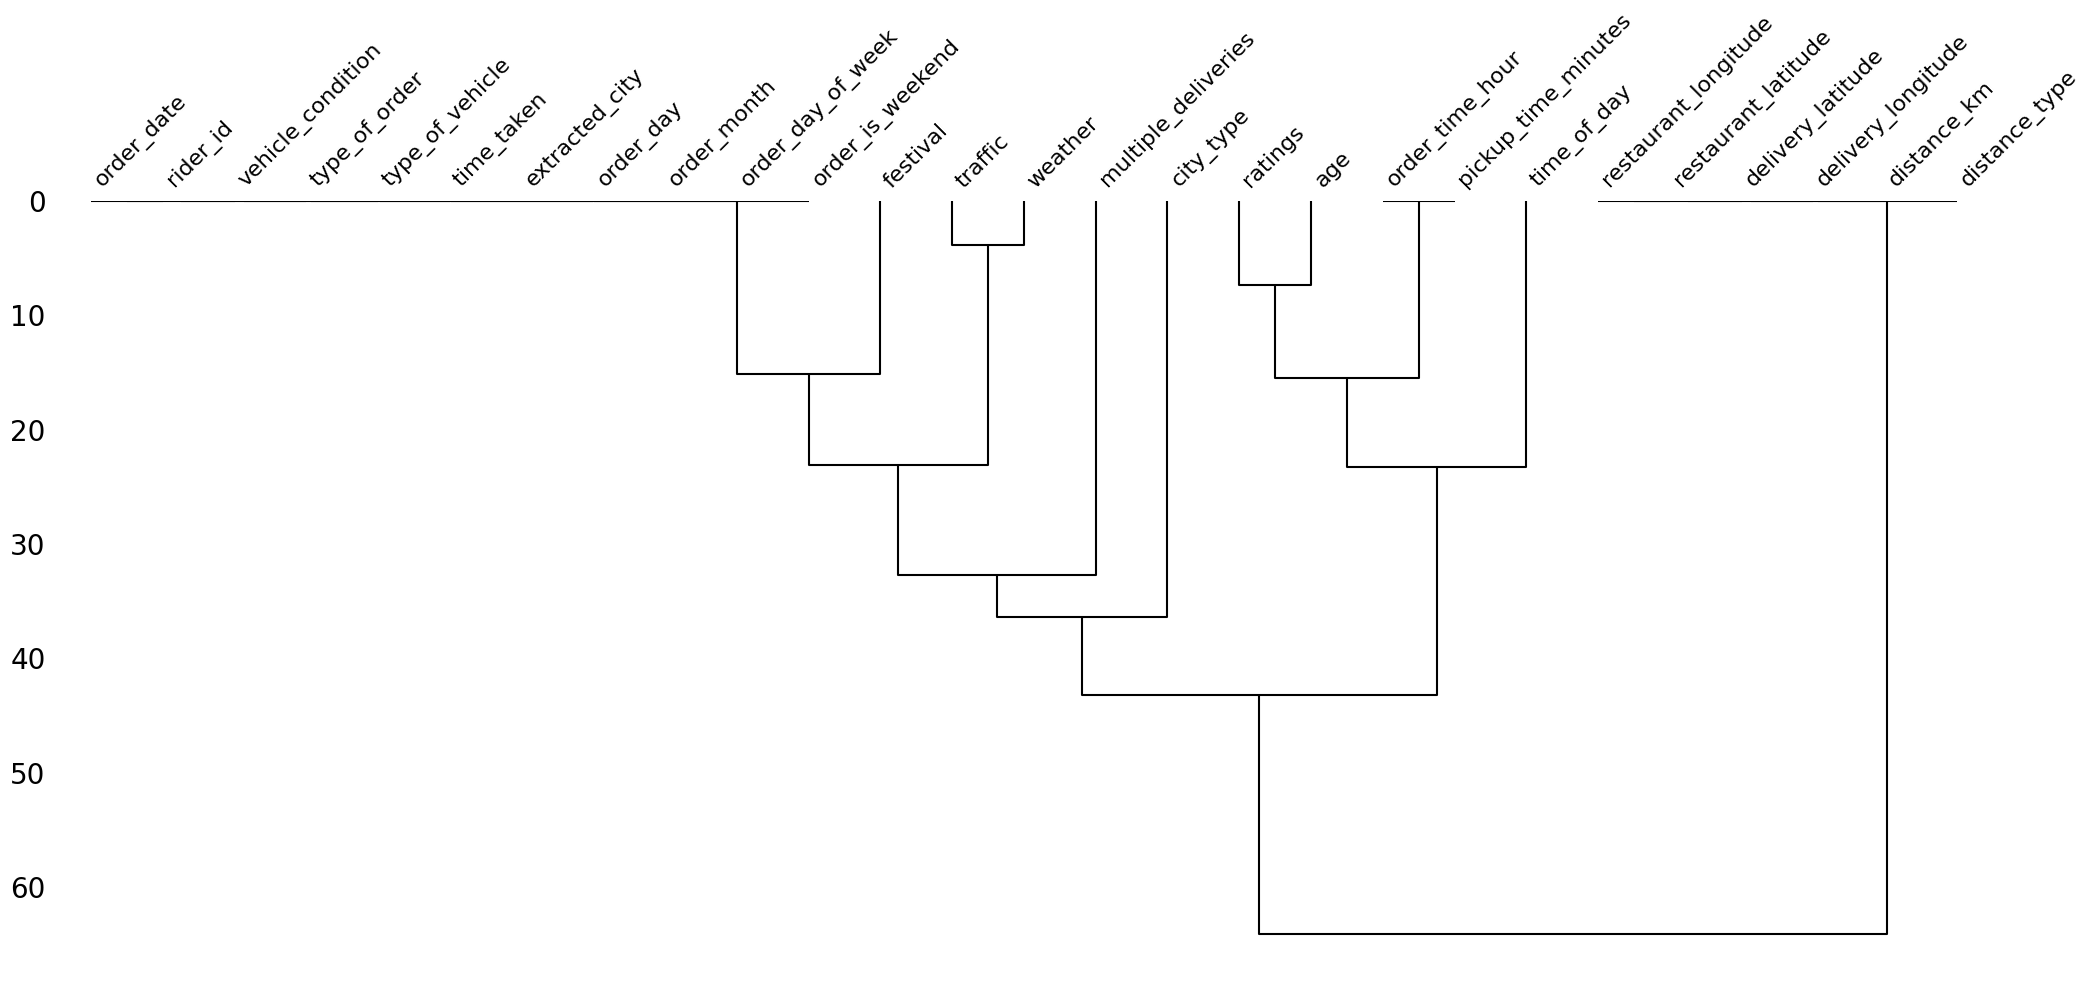

In [15]:
msno.dendrogram(clean_df)

#### Functions for analysis

In [16]:
def numerical_analysis(dataframe, column_name, cat_col=None, bins="auto"):
    # create the figure
    fig = plt.figure(figsize=(15,10))
    # generate the layout
    grid = GridSpec(nrows=2, ncols=2, figure=fig)
    # set subplots
    ax1 = fig.add_subplot(grid[0, 0])
    ax2 = fig.add_subplot(grid[0, 1])
    ax3 = fig.add_subplot(grid[1, :])
    # plot the kdeplot
    sns.kdeplot(data=dataframe, x=column_name,hue=cat_col, ax=ax1)
    # plot the boxplot
    sns.boxplot(data=dataframe, x=column_name,hue=cat_col, ax=ax2)
    # plot the histogram
    sns.histplot(data=dataframe, x=column_name,bins=bins,hue=cat_col,kde=True, ax=ax3)
    plt.tight_layout()
    plt.show()


def numerical_categorical_analysis(dataframe, cat_column_1, num_column):
    fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15,7.5))
    # plot the barplot
    sns.barplot(data=dataframe, x=cat_column_1, y=num_column, ax=ax1[0])
    # plot the boxplot
    sns.boxplot(data=dataframe, x=cat_column_1, y=num_column, ax=ax1[1])
    # plot violin plot
    sns.violinplot(data=dataframe, x=cat_column_1, y=num_column, ax=ax2[0])
    # plot strip plot
    sns.stripplot(data=dataframe, x=cat_column_1, y=num_column, ax=ax2[1])
    plt.tight_layout()
    plt.show()


def categorical_analysis(dataframe, column_name):
    # print the values counts of categories
    display(
        pd.DataFrame({
            "Count": (
                dataframe[column_name]
                .value_counts()),
            "Percentage": (
                dataframe[column_name]
                .value_counts(normalize=True)
                .mul(100)
                .round(2)
                .astype("str")
                .add("%")
                )
        })
    )
    print("*" * 50)
    # get unique categories
    unique_categories = dataframe[column_name].unique().tolist()
    number_of_categories = dataframe[column_name].nunique()
    print(f"The unique categories in {column_name} column are {unique_categories}")
    print("*" * 50)
    print(f"The number of categories in {column_name} column are {number_of_categories}")
    # plot countplot
    sns.countplot(data=dataframe, x=column_name)
    plt.xticks(rotation=45)
    plt.show()


def multivariate_analysis(dataframe, num_column, cat_column_1, cat_column_2):
    fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15,7.5))
    # plot the barplot
    sns.barplot(data=dataframe, x=cat_column_1,
                y=num_column,hue=cat_column_2, ax=ax1[0])
    # plot the boxplot
    sns.boxplot(data=dataframe, x=cat_column_1,
                y=num_column,hue=cat_column_2, gap=0.1, ax=ax1[1])
    # plot violin plot
    sns.violinplot(data=dataframe, x=cat_column_1, gap=0.1,
                   y=num_column,hue=cat_column_2, ax=ax2[0])
    # plot strip plot
    sns.stripplot(data=dataframe, x=cat_column_1,
                  y=num_column,hue=cat_column_2,dodge=True,ax=ax2[1])
    plt.tight_layout()
    plt.show()

def chi_2_test(dataframe, col1, col2, alpha= 0.05):
    data = (
        dataframe.loc[:, [col1, col2]]
        .dropna()
    )
    # create contingency table
    contingency_table = pd.crosstab(data[col1], data[col2])
    # perform chi-squared test
    _, p_val, _, _ = chi2_contingency(contingency_table)
    print(p_val)
    if p_val <= alpha:
        print(f"Reject the null hypothesis. There is a significant association between {col1} and {col2}.")
    else:
        print(f"Fail to reject the null hypothesis. There is no significant association between {col1} and {col2}.")

def anova_test(dataframe, num_col, cat_col, alpha=0.05):
    data = (
        dataframe.loc[:, [num_col, cat_col]]
        .dropna()
    )
    cat_group = data.groupby(cat_col)
    groups = [group[num_col].values for _, group in cat_group]
    f_stat, p_val = f_oneway(*groups)
    print(p_val)
    if p_val <= alpha:
        print(f"Reject the null hypothesis. There is a significant relationship between {num_col} and {cat_col}.")
    else:
        print(f"Fail to reject the null hypothesis. There is no significant relationship between {num_col} and {cat_col}.")

def test_for_normality(dataframe, column_name, alpha=0.05):
    data = dataframe[column_name]
    print("Jarque Bera Test for Normality")
    _, p_val = jarque_bera(data)
    print(p_val)
    if p_val <= alpha:
        print(f"Reject the null hypothesis. The data is not normally distributed.")
    else:
        print(f"Fail to reject the null hypothesis. The data is normally distributed.",end="\n\n")


#### Column wise analysis

In [17]:
clean_df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'extracted_city', 'order_day', 'order_month',
       'order_day_of_week', 'order_is_weekend', 'pickup_time_minutes',
       'order_time_hour', 'time_of_day', 'distance_km', 'distance_type'],
      dtype='object')

#### Time Taken (Target)

In [18]:
clean_df['time_taken'].dtype

dtype('int64')

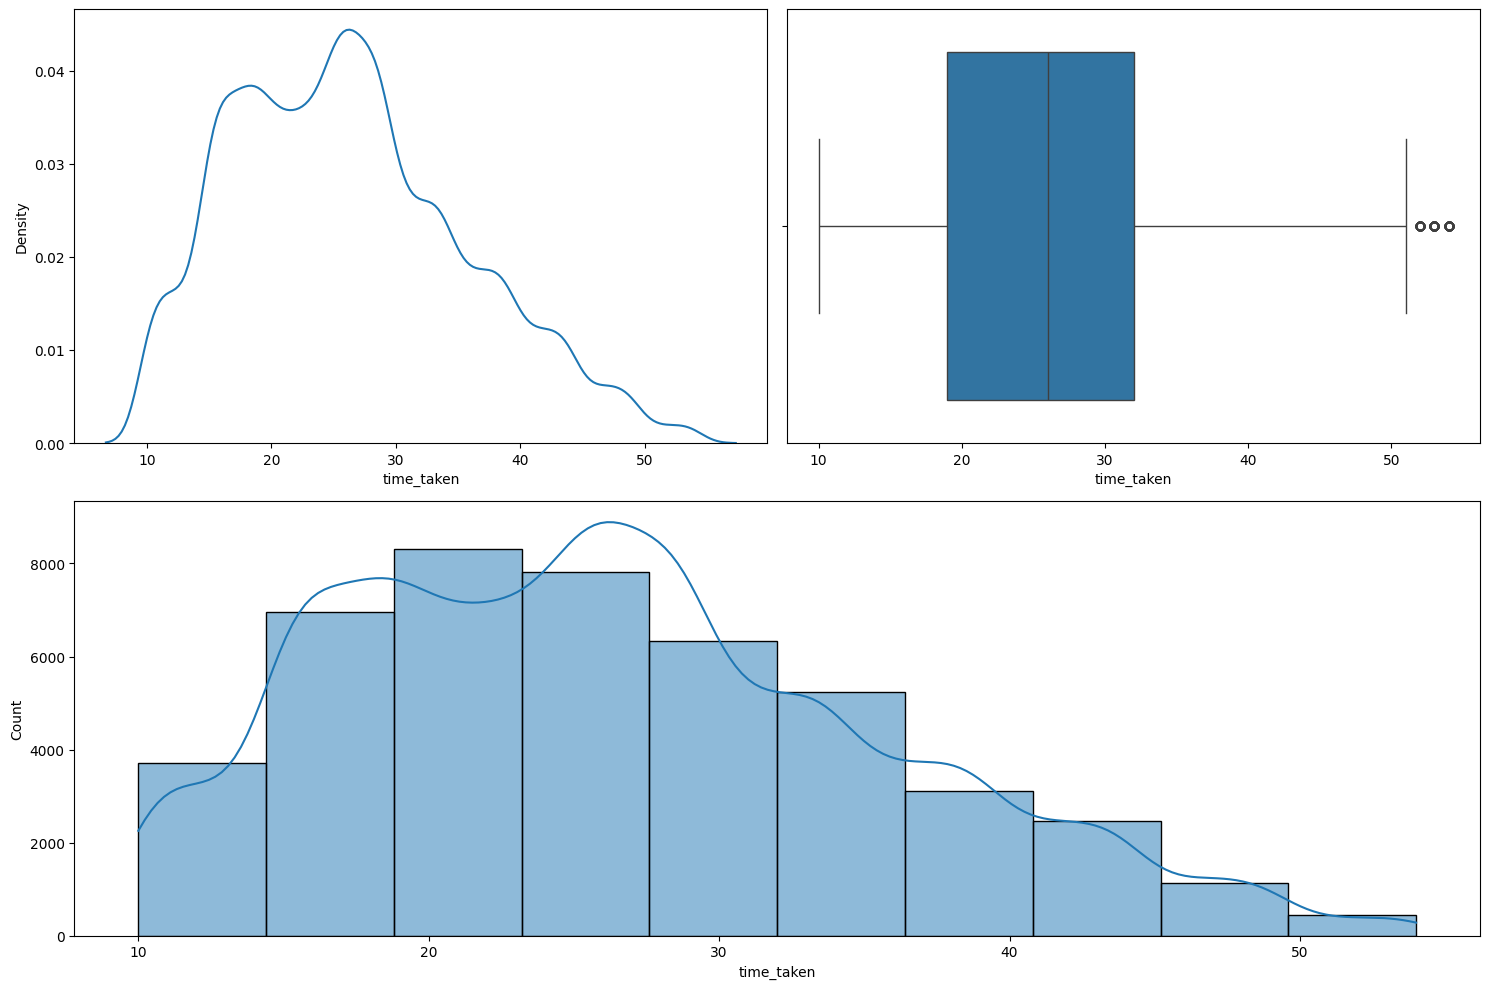

In [19]:
# numerical analysis

numerical_analysis(clean_df, 'time_taken', bins=10)

**Observations**:

1. The target column shows dual modality with two peaks- One peak around the 17-18 mark and other around 26-27 mark.
2. The target column has some extreme points which can be thought of as outliers but they are just extreme and rare, not outliers. 50 min time is possible for delivery in certain rare cases.

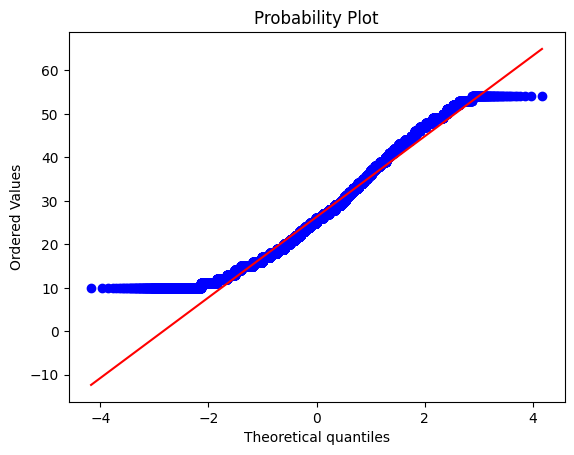

In [20]:
# plot QQ plot for the target

probplot(clean_df['time_taken'], plot=plt)
plt.show()

In [21]:
# tests for normailty

test_for_normality(clean_df, 'time_taken')

Jarque Bera Test for Normality
0.0
Reject the null hypothesis. The data is not normally distributed.


In [22]:
# check out the rows where data is acting as outlier

target_25_per, target_75_per = np.percentile(clean_df['time_taken'], [25, 75])
iqr = target_75_per - target_25_per

upper_bound = target_75_per + (1.5 * iqr)

clean_df.loc[(clean_df['time_taken'] > upper_bound),"traffic"].value_counts()

traffic
jam     241
high     24
Name: count, dtype: int64

In [23]:
clean_df.loc[(clean_df['time_taken'] > upper_bound),"weather"].value_counts()

weather
fog           57
sunny         51
windy         44
cloudy        44
stormy        37
sandstorms    32
Name: count, dtype: int64

In [24]:
# average distances
avg_distance = clean_df.loc[:,"distance_km"].mean()
avg_distance_extreme = clean_df.loc[(clean_df['time_taken'] > upper_bound),"distance_km"].mean()

print(avg_distance, avg_distance_extreme)

9.703310553452345 13.270475936108802


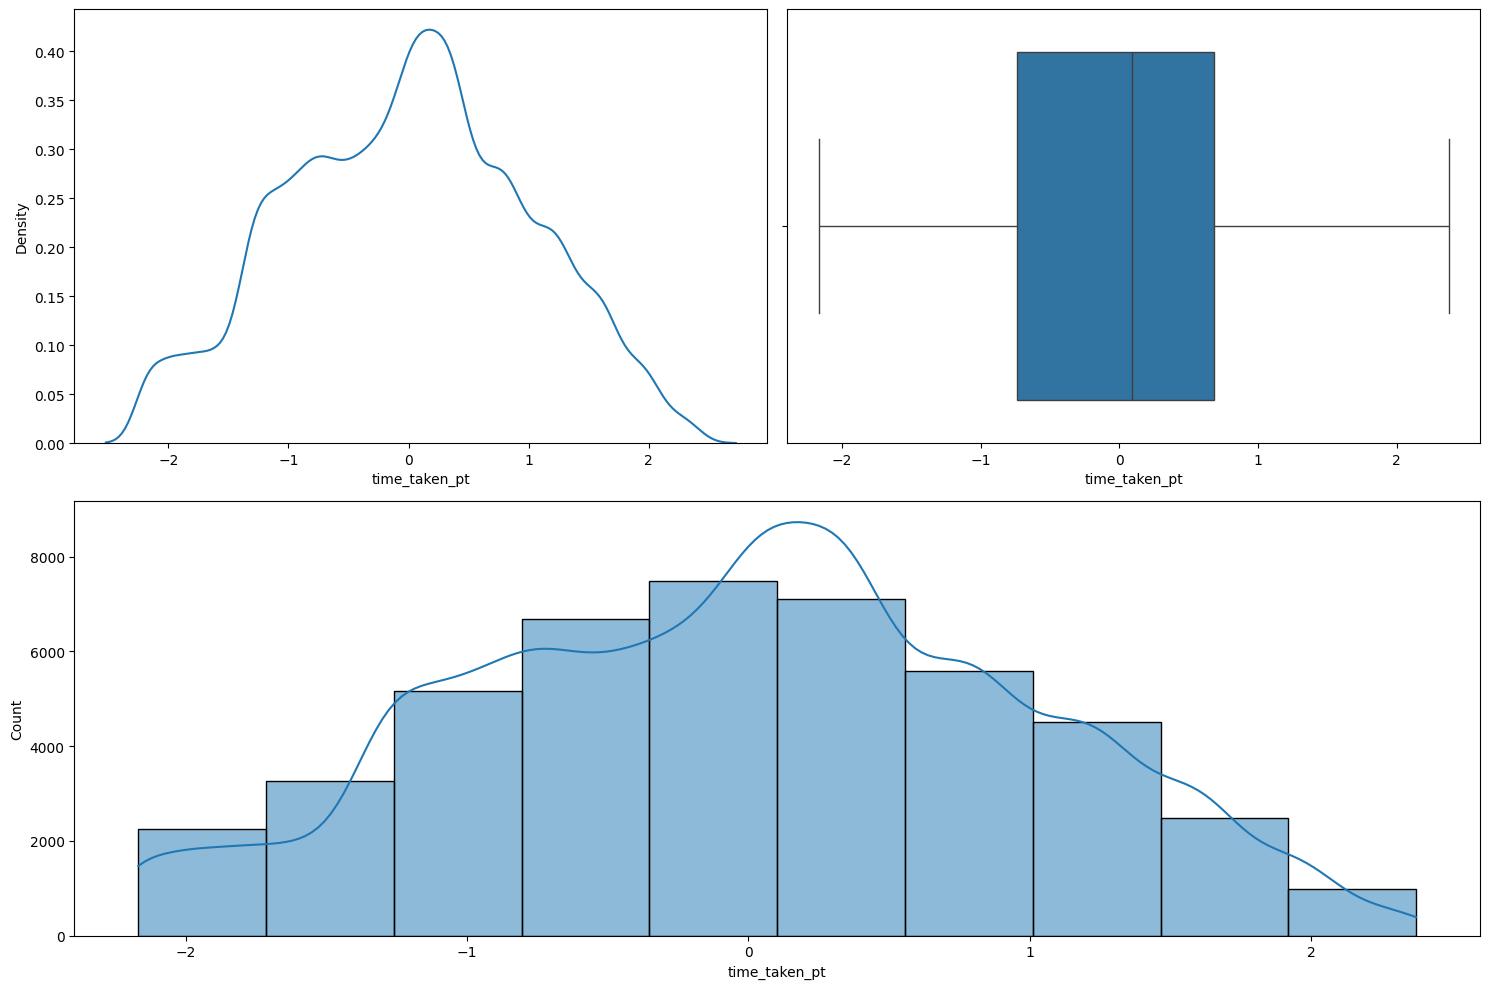

In [25]:
# fix traget column using transformation

from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')

clean_df['time_taken_pt'] = pt.fit_transform(clean_df[['time_taken']])

numerical_analysis(clean_df, "time_taken_pt", bins=10)

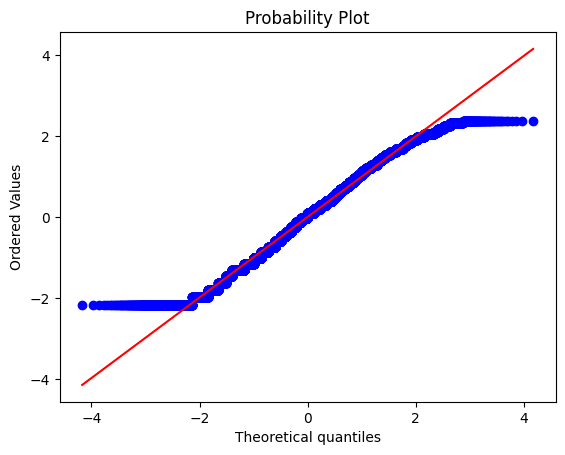

In [26]:
#  plot QQ plot for the target after transformation

probplot(clean_df['time_taken_pt'], plot=plt)
plt.show()

#### Rider_ID

In [27]:
# datatype of rider id

clean_df['rider_id'].dtype

dtype('O')

In [28]:
clean_df[["rider_id","age","ratings"]]

rider_id   age  ratings
0        INDORES13DEL02   37.0      4.9
1        BANGRES18DEL02   34.0      4.5
2        BANGRES19DEL01   23.0      4.4
3       COIMBRES13DEL02   38.0      4.7
4        CHENRES12DEL01   32.0      4.6
...                  ...   ...      ...
45588     JAPRES04DEL01   30.0      4.8
45589     AGRRES16DEL01   21.0      4.6
45590    CHENRES08DEL03   30.0      4.9
45591   COIMBRES11DEL01   20.0      4.7
45592  RANCHIRES09DEL02   23.0      4.9

[45502 rows x 3 columns]

In [29]:
# sample of data

rider_id_group = clean_df[["rider_id","age","ratings"]].groupby('rider_id')
rider_id_group.head(5).sort_values('rider_id')

rider_id   age  ratings
92     AGRRES010DEL01   34.0      4.7
7750   AGRRES010DEL01   21.0      4.7
4558   AGRRES010DEL01   38.0      4.7
12437  AGRRES010DEL01   34.0      4.5
13244  AGRRES010DEL01   39.0      4.4
...                ...   ...      ...
861     VADRES20DEL03   35.0      4.8
9807    VADRES20DEL03   30.0      4.6
9768    VADRES20DEL03   38.0      4.8
5099    VADRES20DEL03   35.0      4.9
5151    VADRES20DEL03   37.0      4.9

[6600 rows x 3 columns]

In [30]:
# check for duplicates

clean_df[["rider_id","age","ratings"]].dropna().duplicated(keep=False).sum()

np.int64(10155)

In [31]:
clean_df.loc[(clean_df[["rider_id","age","ratings"]].duplicated(keep=False)),["rider_id","age","ratings"]].dropna().sort_values(["rider_id"])

rider_id   age  ratings
18566  AGRRES03DEL02   24.0      4.9
40368  AGRRES03DEL02   24.0      4.9
28531  AGRRES03DEL03   30.0      4.7
26325  AGRRES03DEL03   30.0      4.7
36203  AGRRES06DEL02   36.0      4.9
...               ...   ...      ...
12763  VADRES20DEL02   28.0      4.5
5099   VADRES20DEL03   35.0      4.9
17996  VADRES20DEL03   35.0      4.9
21995  VADRES20DEL03   37.0      4.9
5151   VADRES20DEL03   37.0      4.9

[10155 rows x 3 columns]

#### Age

In [32]:
# data type of age column

clean_df['age'].dtype

dtype('float64')

In [33]:
# statistical summary

clean_df['age'].describe()

count    43648.000000
mean        29.555008
std          5.761482
min         20.000000
25%         25.000000
50%         30.000000
75%         35.000000
max         39.000000
Name: age, dtype: float64

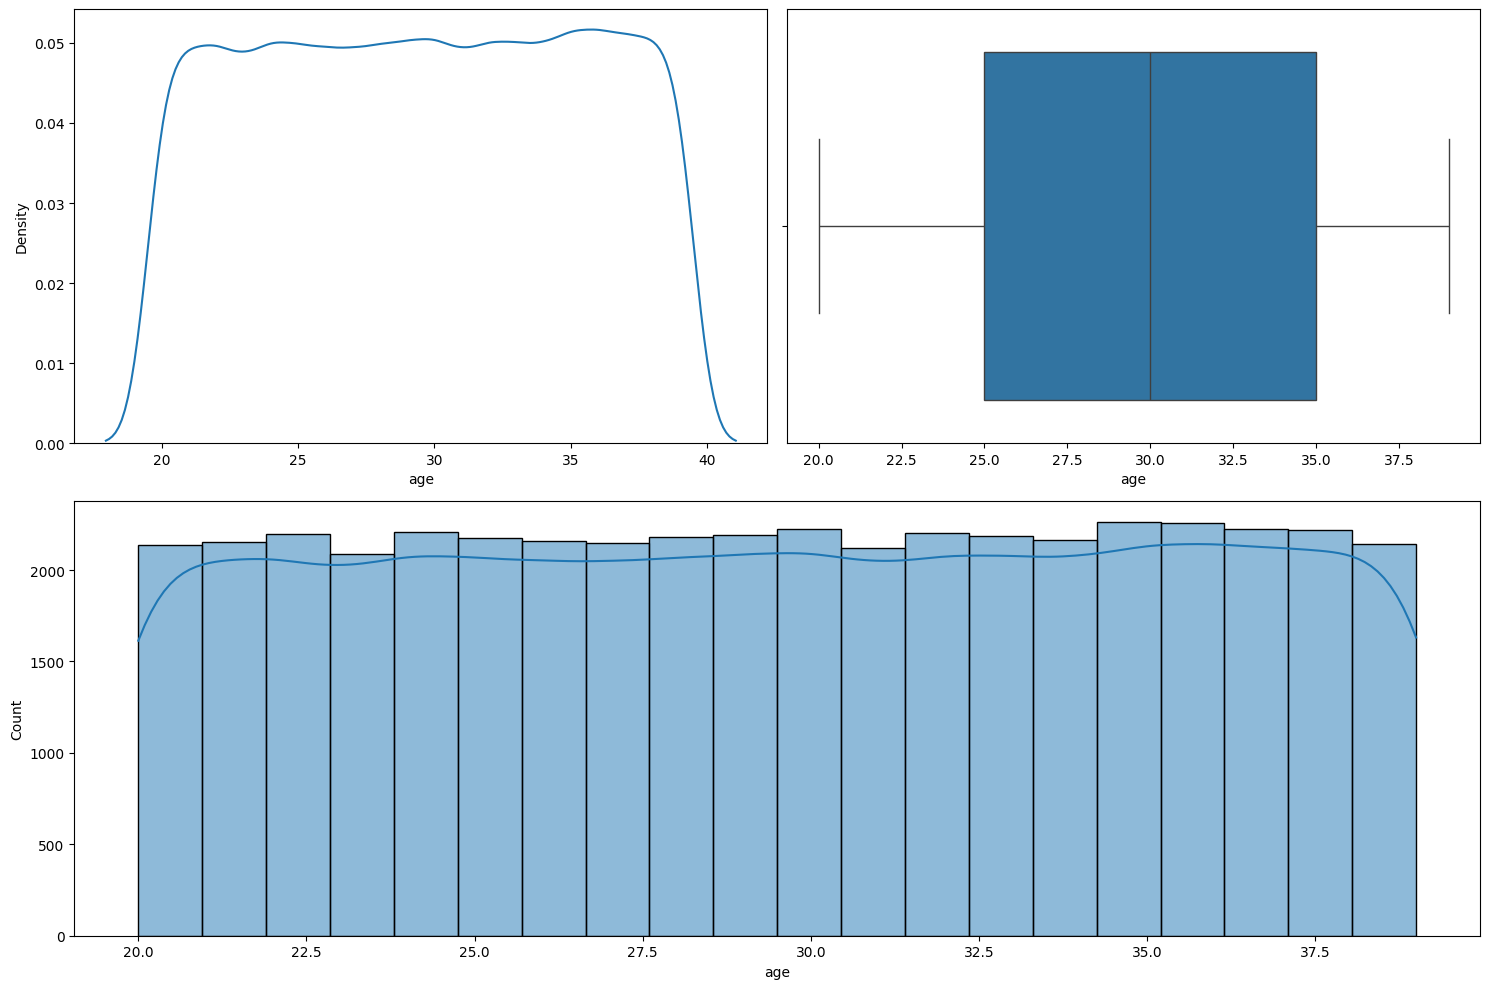

In [34]:
# numerical analysis for age

numerical_analysis(clean_df, 'age',bins=20)

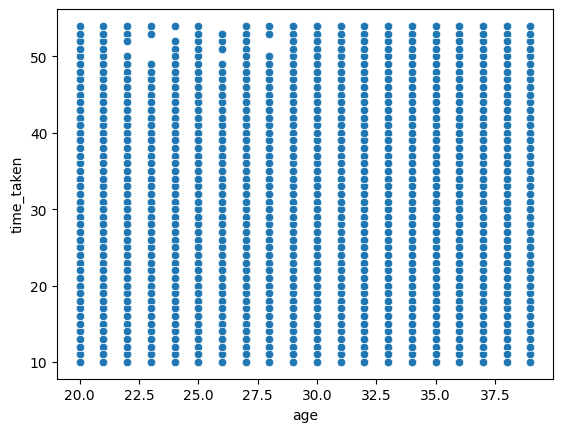

In [35]:
# relationship between target and age

sns.scatterplot(data = clean_df, x = 'age', y = 'time_taken')
plt.show()

- Age of the rider doesn't show any impact on time taken.

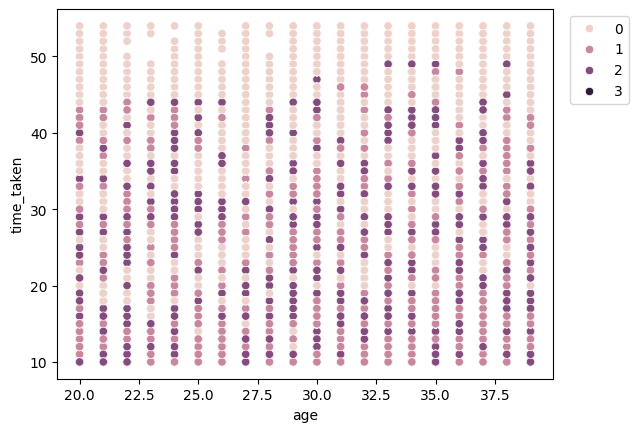

In [36]:
sns.scatterplot(data = clean_df, x = 'age', y = 'time_taken', hue = "vehicle_condition")
plt.legend(bbox_to_anchor=(1.02, 1), loc = 2)
plt.show()

<Axes: xlabel='type_of_vehicle', ylabel='age'>

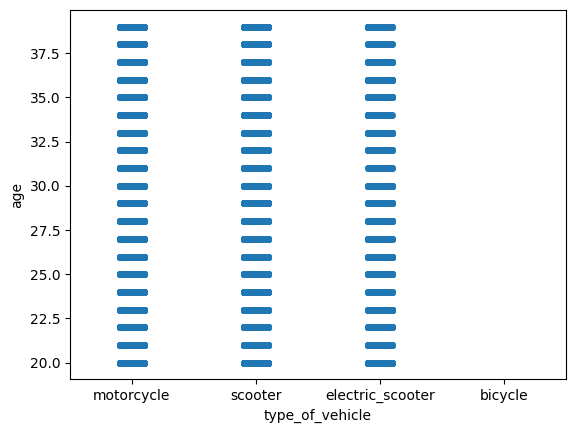

In [37]:
# preferences of vehicle type based on age

sns.stripplot(clean_df, x = 'type_of_vehicle', y = 'age')

#### Ratings

In [38]:
# data type of rating column

clean_df['ratings'].dtype

dtype('float64')

In [39]:
# statistical summary

clean_df['ratings'].describe()

count    43594.000000
mean         4.635287
std          0.313827
min          2.500000
25%          4.500000
50%          4.700000
75%          4.900000
max          5.000000
Name: ratings, dtype: float64

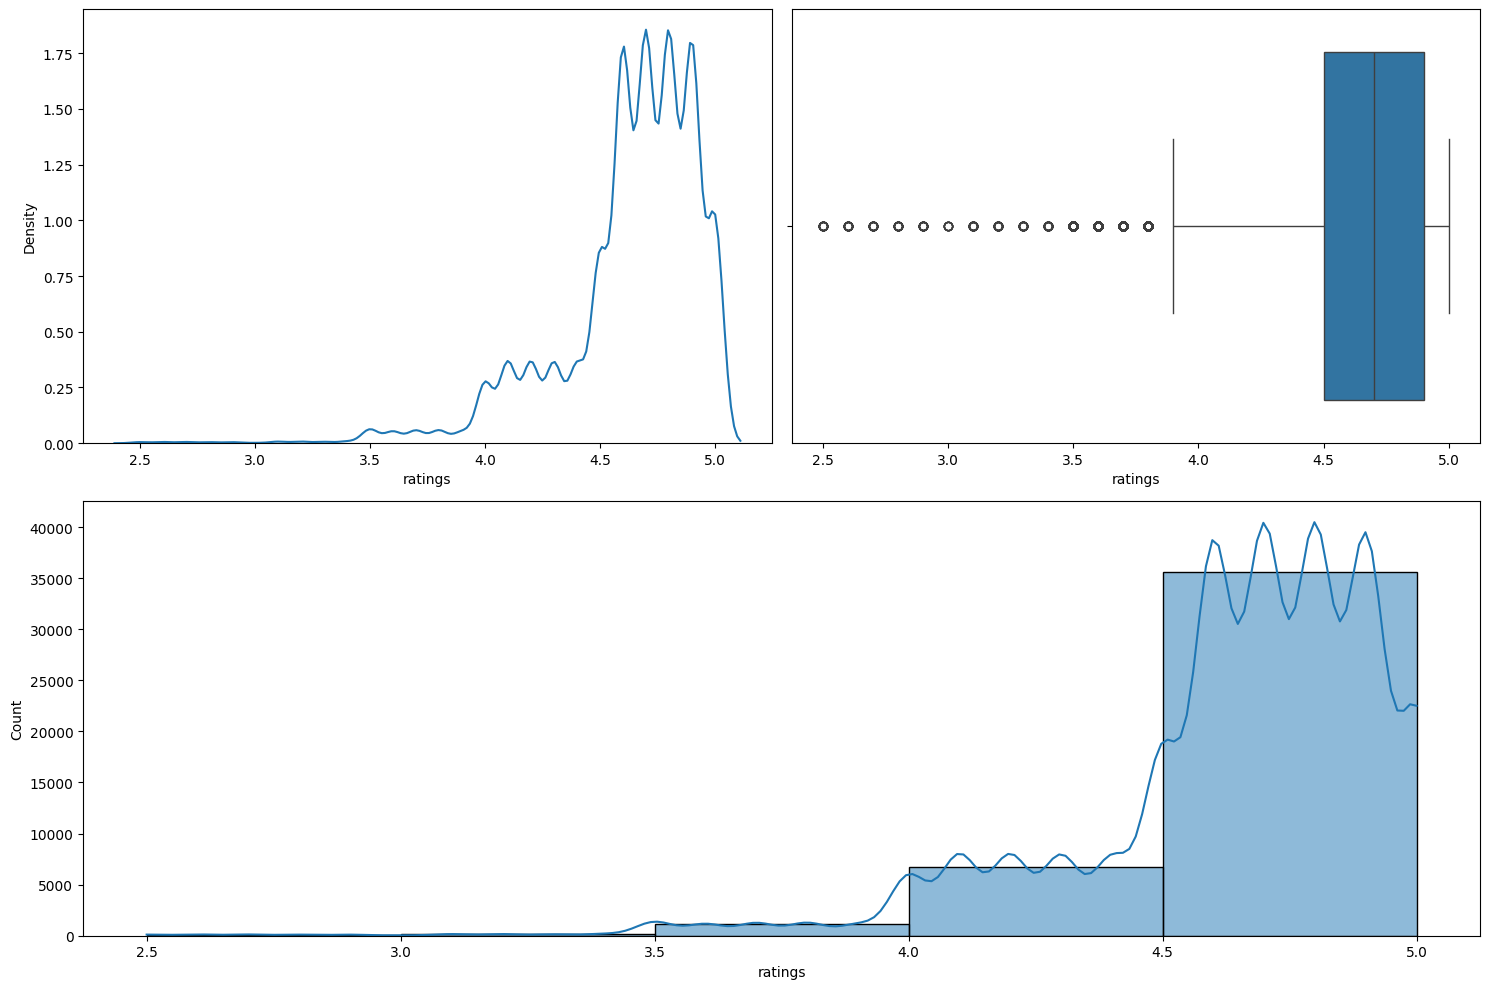

In [40]:
# numerical analysis

numerical_analysis(clean_df, 'ratings', bins = 5)

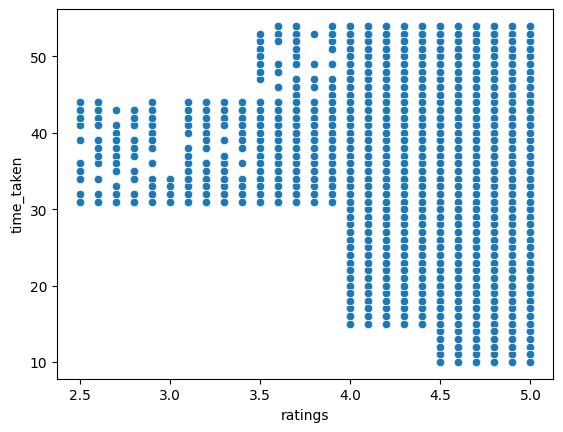

In [41]:
# does ratings affect delivery time

sns.scatterplot(data = clean_df, x = 'ratings', y = 'time_taken')
plt.show()

- It seems like riders with more ratings get more orders
- Higher ratings equates to more work and more income opportunities

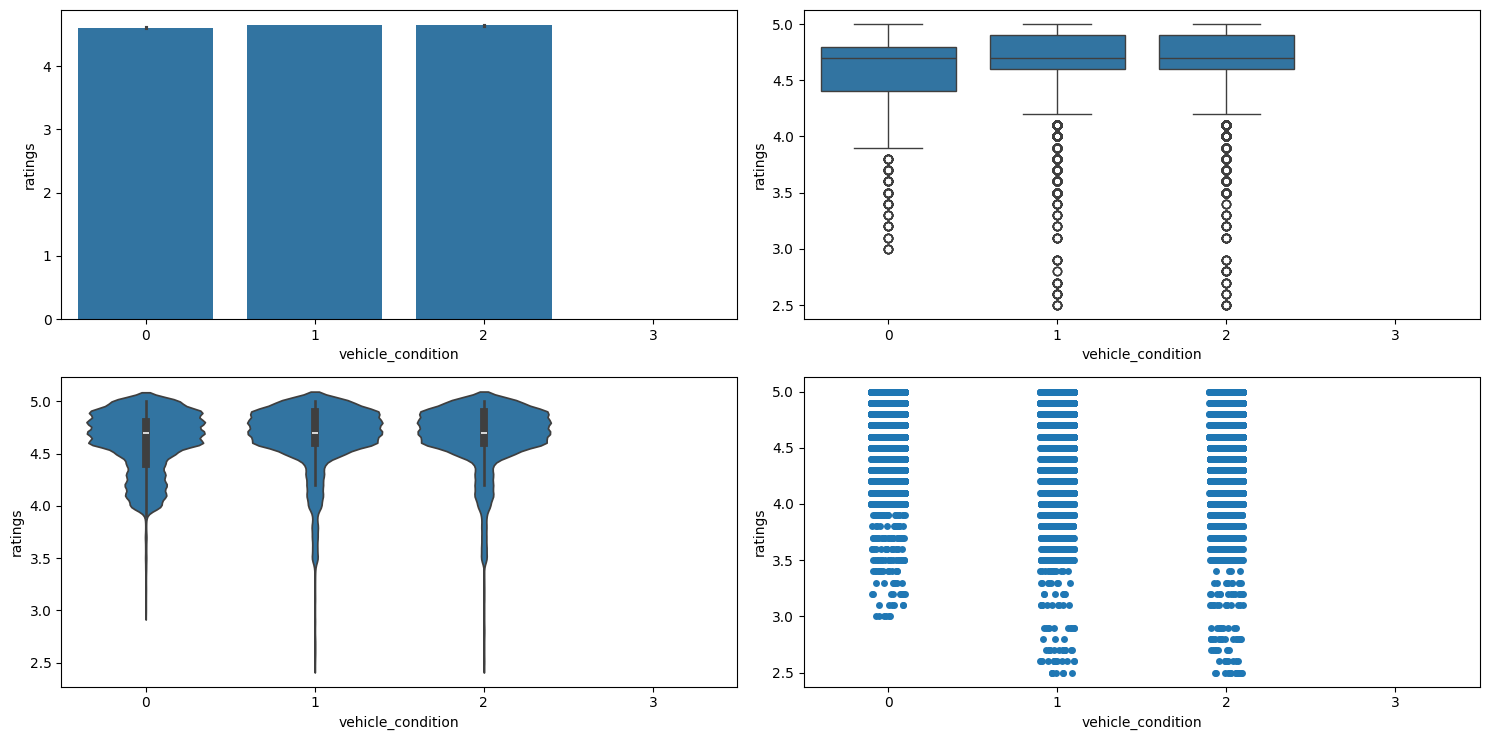

In [42]:
# does ratings get affected by vehicle type

numerical_categorical_analysis(clean_df, 'vehicle_condition', 'ratings')

**Yes they do**

- The more worst the vehicle condition is, the more lower the rating gets.
- The category 3 has no data means there are NaN values. This simply means that customers avoid rating their riders even rating of 1 when the vehicle condition is bad.

In [43]:
clean_df[["ratings","vehicle_condition"]].loc[clean_df["vehicle_condition"]==3,"ratings"].value_counts(dropna=False)

ratings
NaN    429
Name: count, dtype: int64

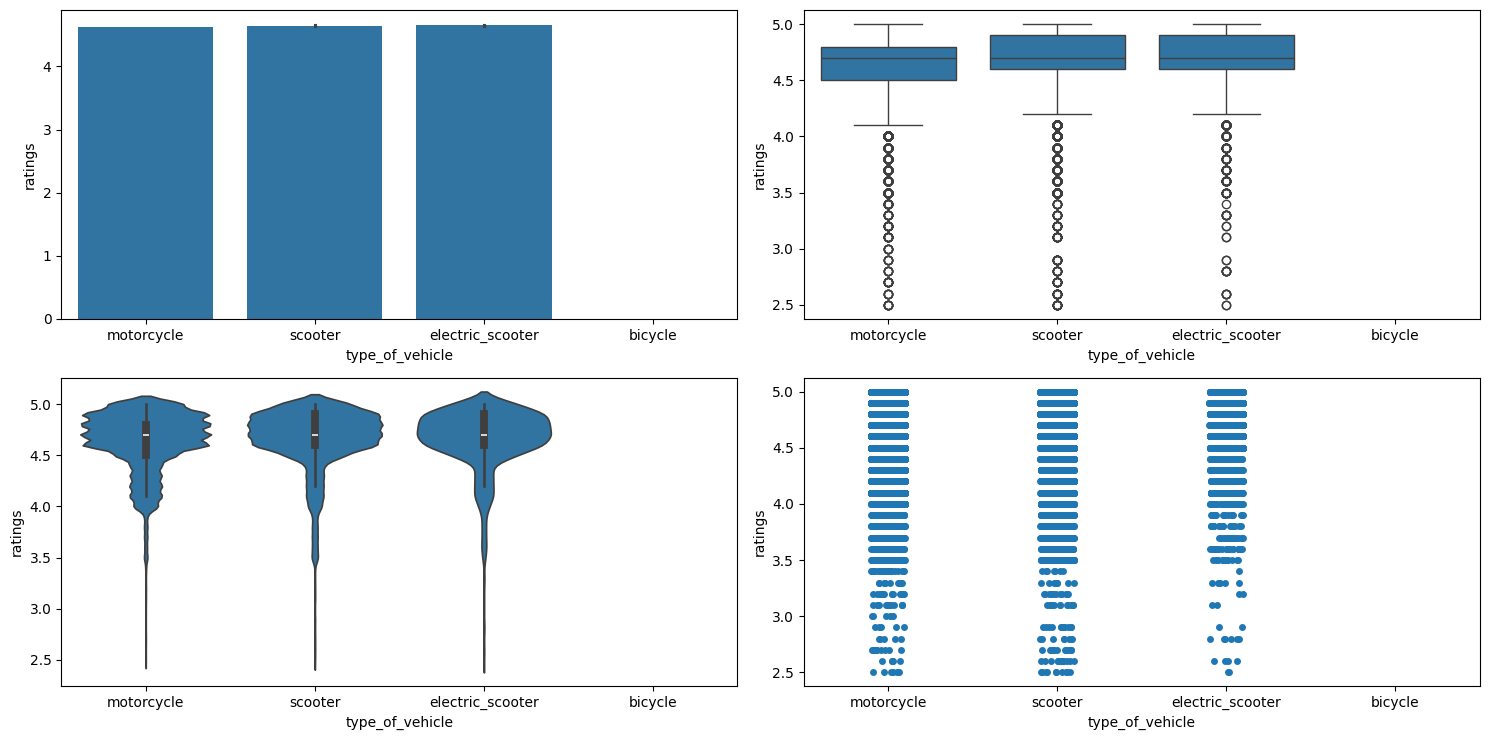

In [44]:
# does type of vehicle affects ratings

numerical_categorical_analysis(clean_df, 'type_of_vehicle', 'ratings')

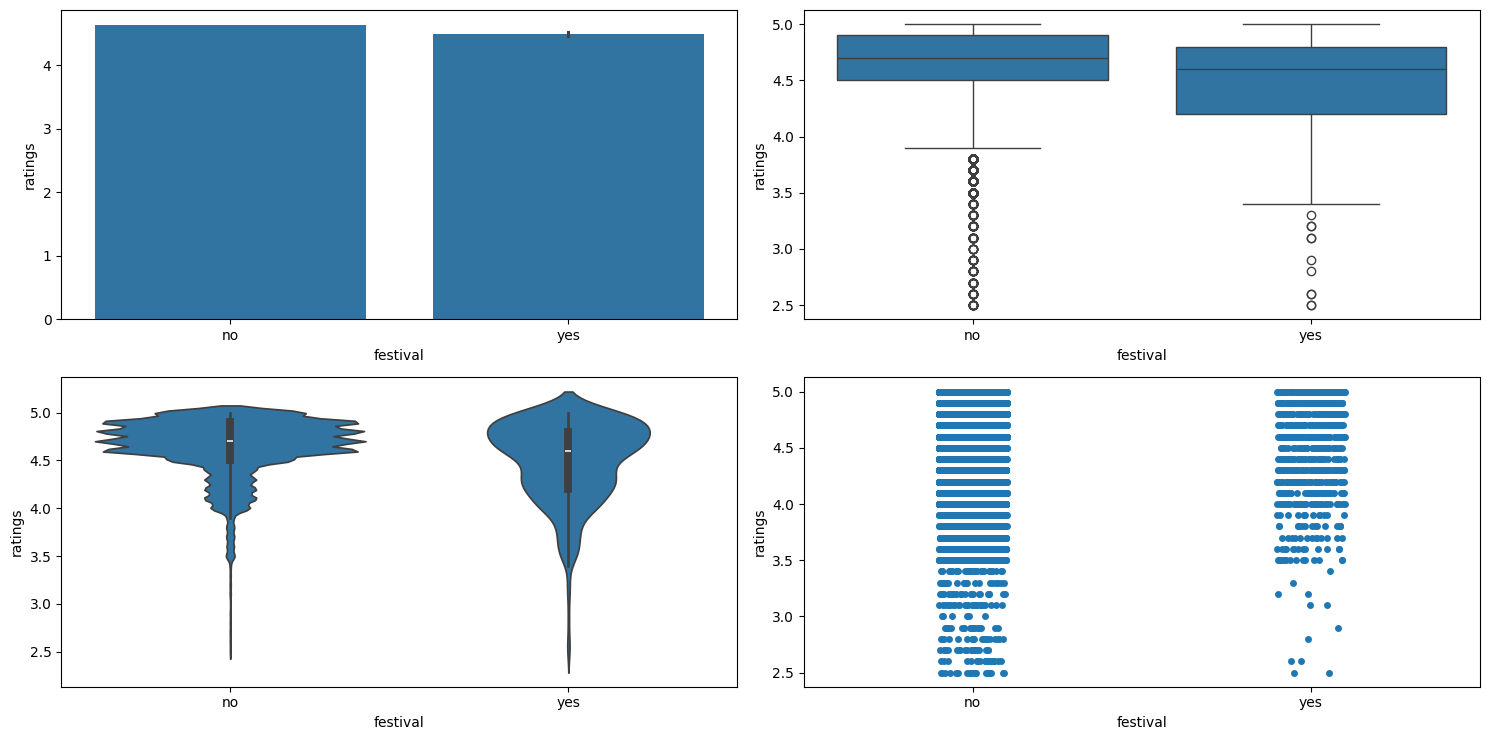

In [45]:
# festivals and rider ratings

numerical_categorical_analysis(clean_df, 'festival', 'ratings')

#### Location based features

In [46]:
clean_df.columns[3:7].tolist() + ["extracted_city"]

['restaurant_latitude',
 'restaurant_longitude',
 'delivery_latitude',
 'delivery_longitude',
 'extracted_city']

In [47]:
# location subset

location_subset = clean_df.loc[:,clean_df.columns[3:7].tolist() + ["extracted_city"]]

location_subset

restaurant_latitude  restaurant_longitude  delivery_latitude  \
0                22.745049             75.892471          22.765049   
1                12.913041             77.683237          13.043041   
2                12.914264             77.678400          12.924264   
3                11.003669             76.976494          11.053669   
4                12.972793             80.249982          13.012793   
...                    ...                   ...                ...   
45588            26.902328             75.794257          26.912328   
45589                  NaN                   NaN                NaN   
45590            13.022394             80.242439          13.052394   
45591            11.001753             76.986241          11.041753   
45592            23.351058             85.325731          23.431058   

       delivery_longitude extracted_city  
0               75.912471           INDO  
1               77.813237           BANG  
2               77.688400           BANG  
3               77.026494          COIMB  
4               80.289982           CHEN  
...                   ...            ...  
45588           75.804257            JAP  
45589                 NaN            AGR  
45590           80.272439           CHEN  
45591           77.026241          COIMB  
45592           85.405731         RANCHI  

[45502 rows x 5 columns]

In [48]:
location_subset.dtypes

restaurant_latitude     float64
restaurant_longitude    float64
delivery_latitude       float64
delivery_longitude      float64
extracted_city           object
dtype: object

In [49]:
# drop missing values

location_subset.dropna(inplace=True)

location_subset

restaurant_latitude  restaurant_longitude  delivery_latitude  \
0                22.745049             75.892471          22.765049   
1                12.913041             77.683237          13.043041   
2                12.914264             77.678400          12.924264   
3                11.003669             76.976494          11.053669   
4                12.972793             80.249982          13.012793   
...                    ...                   ...                ...   
45587            23.371292             85.327872          23.481292   
45588            26.902328             75.794257          26.912328   
45590            13.022394             80.242439          13.052394   
45591            11.001753             76.986241          11.041753   
45592            23.351058             85.325731          23.431058   

       delivery_longitude extracted_city  
0               75.912471           INDO  
1               77.813237           BANG  
2               77.688400           BANG  
3               77.026494          COIMB  
4               80.289982           CHEN  
...                   ...            ...  
45587           85.437872         RANCHI  
45588           75.804257            JAP  
45590           80.272439           CHEN  
45591           77.026241          COIMB  
45592           85.405731         RANCHI  

[41872 rows x 5 columns]

In [50]:
! pip install ipython



In [51]:
# plot deliveries on map

delivery_df = pd.DataFrame({
    'latitude': location_subset['delivery_latitude'],
    'longitude': location_subset['delivery_longitude'],
    "city_name": location_subset["extracted_city"]
})


# Create a map using Plotly's scatter_mapbox
fig = px.scatter_map(
    delivery_df,
    lat='latitude',
    lon='longitude',
    title="Delivery Points",
    hover_name="city_name"
)

# Update the layout for the map of India
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center={"lat": 20.5937, "lon": 78.9629},  # Centered over India
    mapbox_zoom=3,
)

# Show the plot
fig.show()

#### Order Date

In [52]:
clean_df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'extracted_city', 'order_day', 'order_month',
       'order_day_of_week', 'order_is_weekend', 'pickup_time_minutes',
       'order_time_hour', 'time_of_day', 'distance_km', 'distance_type',
       'time_taken_pt'],
      dtype='object')

In [53]:
clean_df.filter(like = "order")

order_date type_of_order order_day order_month  \
0      2022-03-19 00:00:00         snack        19           3   
1      2022-03-25 00:00:00         snack        25           3   
2      2022-03-19 00:00:00        drinks        19           3   
3      2022-04-05 00:00:00        buffet         5           4   
4      2022-03-26 00:00:00         snack        26           3   
...                    ...           ...       ...         ...   
45588  2022-03-24 00:00:00          meal        24           3   
45589  2022-02-16 00:00:00        buffet        16           2   
45590  2022-03-11 00:00:00        drinks        11           3   
45591  2022-03-07 00:00:00         snack         7           3   
45592  2022-03-02 00:00:00         snack         2           3   

      order_day_of_week order_is_weekend order_time_hour  
0              Saturday                1            11.0  
1                Friday                0            19.0  
2              Saturday                1             8.0  
3               Tuesday                0            18.0  
4              Saturday                1            13.0  
...                 ...              ...             ...  
45588          Thursday                0            11.0  
45589         Wednesday                0            19.0  
45590            Friday                0            23.0  
45591            Monday                0            13.0  
45592         Wednesday                0            17.0  

[45502 rows x 7 columns]

In [54]:
# order date columns

order_date_subset = clean_df.loc[:,["order_date", "order_day", "order_month", "order_day_of_week", "order_is_weekend", "festival"]]

order_date_subset

order_date order_day order_month order_day_of_week  \
0      2022-03-19 00:00:00        19           3          Saturday   
1      2022-03-25 00:00:00        25           3            Friday   
2      2022-03-19 00:00:00        19           3          Saturday   
3      2022-04-05 00:00:00         5           4           Tuesday   
4      2022-03-26 00:00:00        26           3          Saturday   
...                    ...       ...         ...               ...   
45588  2022-03-24 00:00:00        24           3          Thursday   
45589  2022-02-16 00:00:00        16           2         Wednesday   
45590  2022-03-11 00:00:00        11           3            Friday   
45591  2022-03-07 00:00:00         7           3            Monday   
45592  2022-03-02 00:00:00         2           3         Wednesday   

      order_is_weekend festival  
0                    1       no  
1                    0       no  
2                    1       no  
3                    0       no  
4                    1       no  
...                ...      ...  
45588                0       no  
45589                0       no  
45590                0       no  
45591                0       no  
45592                0       no  

[45502 rows x 6 columns]

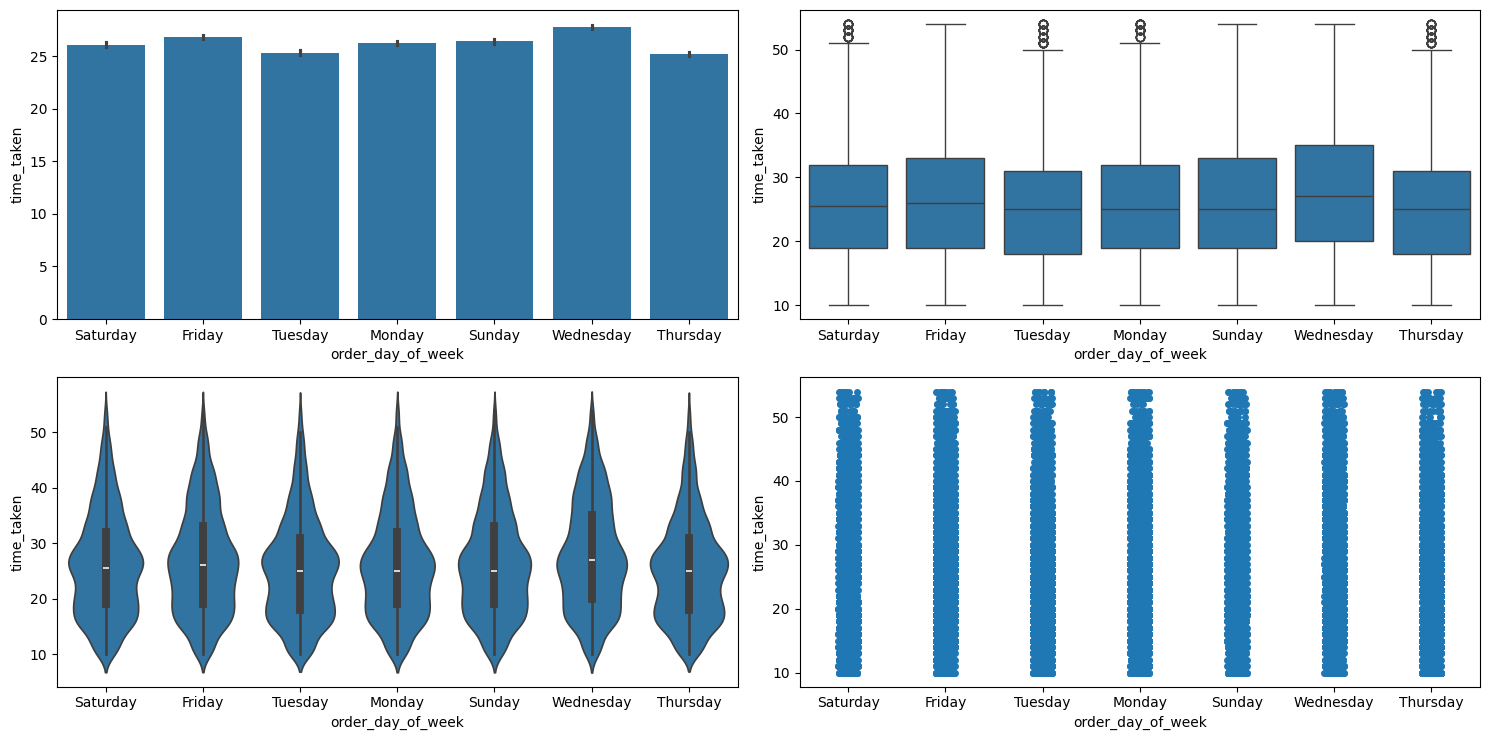

In [55]:
# analysis between day of week and target

numerical_categorical_analysis(clean_df, "order_day_of_week", "time_taken")

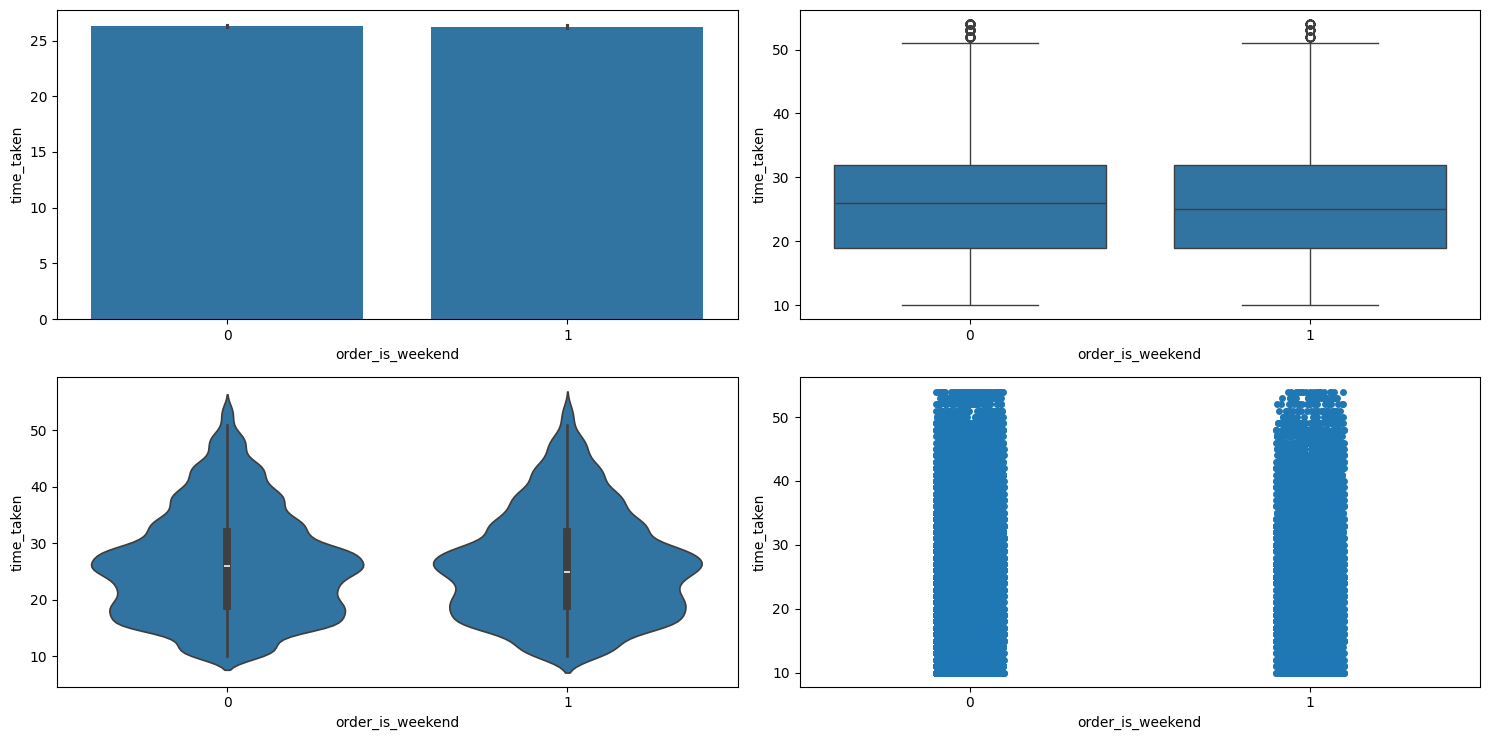

In [56]:
# does having a weekend affects target

numerical_categorical_analysis(clean_df, "order_is_weekend", "time_taken")

In [57]:
# do weekends have an impact on traffic

chi_2_test(clean_df, "order_is_weekend", "traffic")

0.6845961396354259
Fail to reject the null hypothesis. There is no significant association between order_is_weekend and traffic.


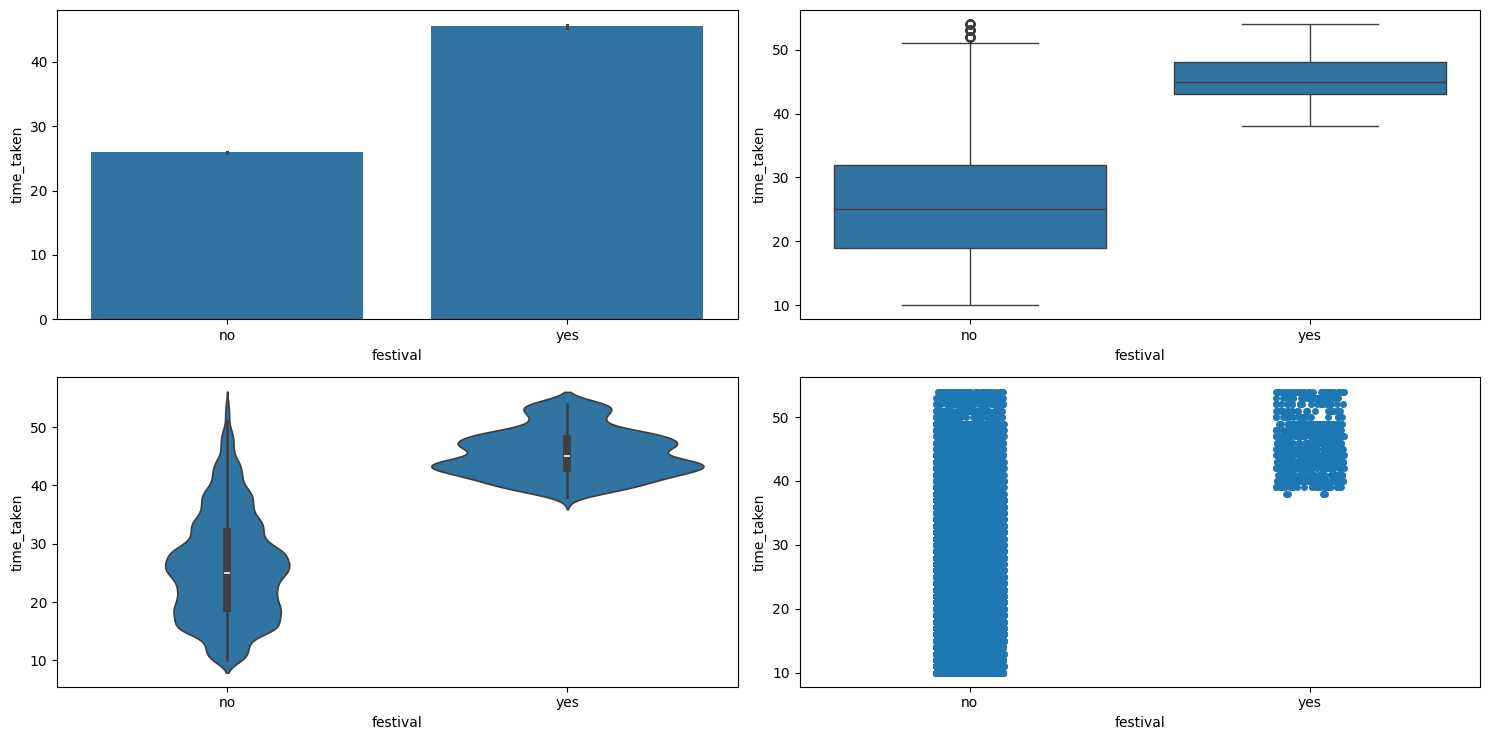

In [58]:
# festivals and target analysis

numerical_categorical_analysis(clean_df, "festival", "time_taken")

**Observations**:
1. The avg time it takes for delivery varies when there is a festival.
2. The range of delivery time is shorter when there is a festival with lesser variation, which means on a festival delivery times usually takes longer.

In [59]:
# do festival affect traffic

chi_2_test(clean_df, "festival", "traffic")

1.1223471129146869e-153
Reject the null hypothesis. There is a significant association between festival and traffic.


- The p value is very small which mans it does affect traffic.

In [60]:
clean_df.pivot_table(index = "traffic", columns = "festival", values = "time_taken", aggfunc = "mean")

festival         no        yes
traffic                       
high      27.010373  45.826087
jam       30.538039  46.093651
low       21.284332  42.020000
medium    26.550288  43.715385

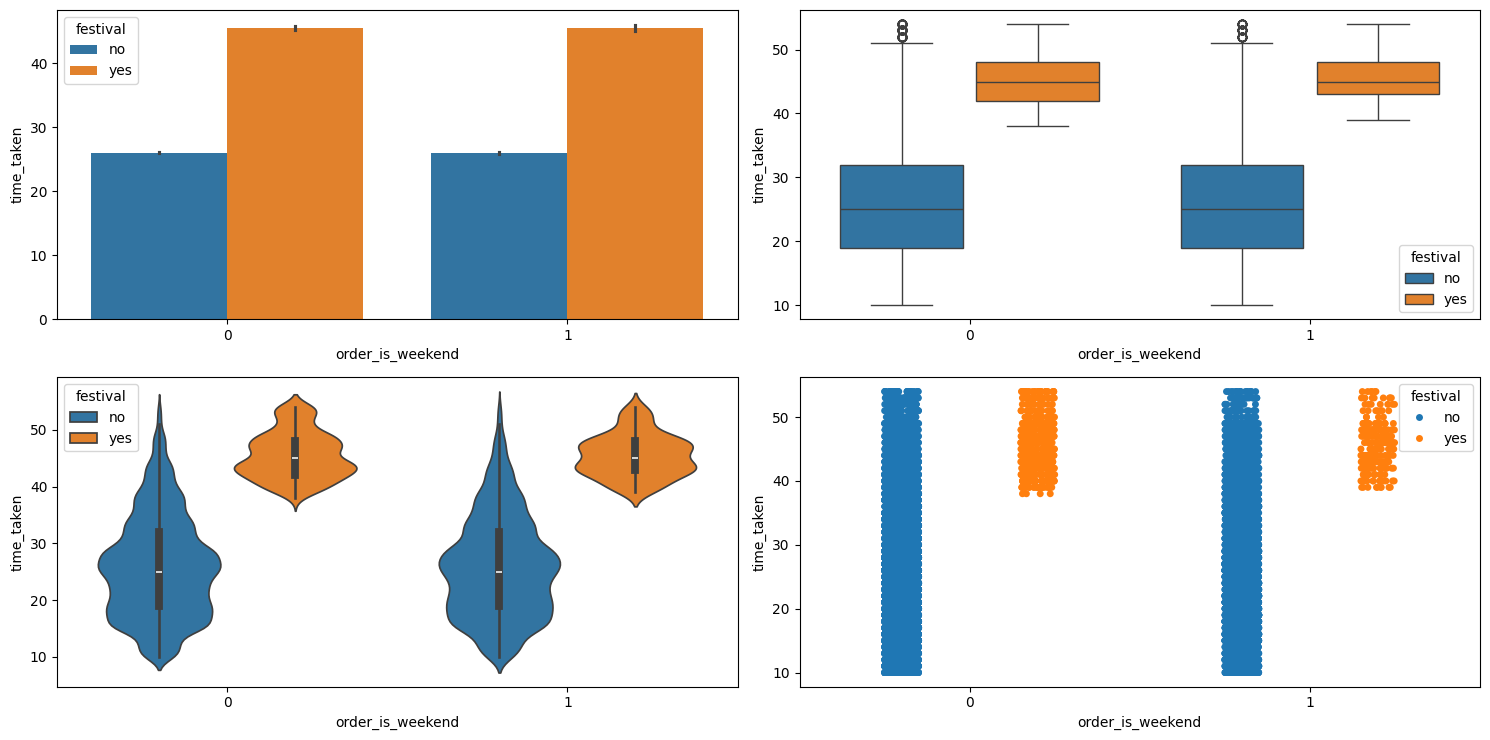

In [61]:
# does a weekend and a festival combined have an effect on delivery times

multivariate_analysis(clean_df, "time_taken", "order_is_weekend", "festival")

#### Order Time

In [62]:
clean_df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'extracted_city', 'order_day', 'order_month',
       'order_day_of_week', 'order_is_weekend', 'pickup_time_minutes',
       'order_time_hour', 'time_of_day', 'distance_km', 'distance_type',
       'time_taken_pt'],
      dtype='object')

In [63]:
# time related columns

time_subset = clean_df.loc[:,["order_time_hour", "time_of_day", "pickup_time_minutes"]]

time_subset

order_time_hour time_of_day  pickup_time_minutes
0                11.0     morning                 15.0
1                19.0     evening                  5.0
2                 8.0     morning                 15.0
3                18.0     evening                 10.0
4                13.0   afternoon                 15.0
...               ...         ...                  ...
45588            11.0     morning                 10.0
45589            19.0     evening                 15.0
45590            23.0       night                 15.0
45591            13.0   afternoon                  5.0
45592            17.0   afternoon                  5.0

[45502 rows x 3 columns]

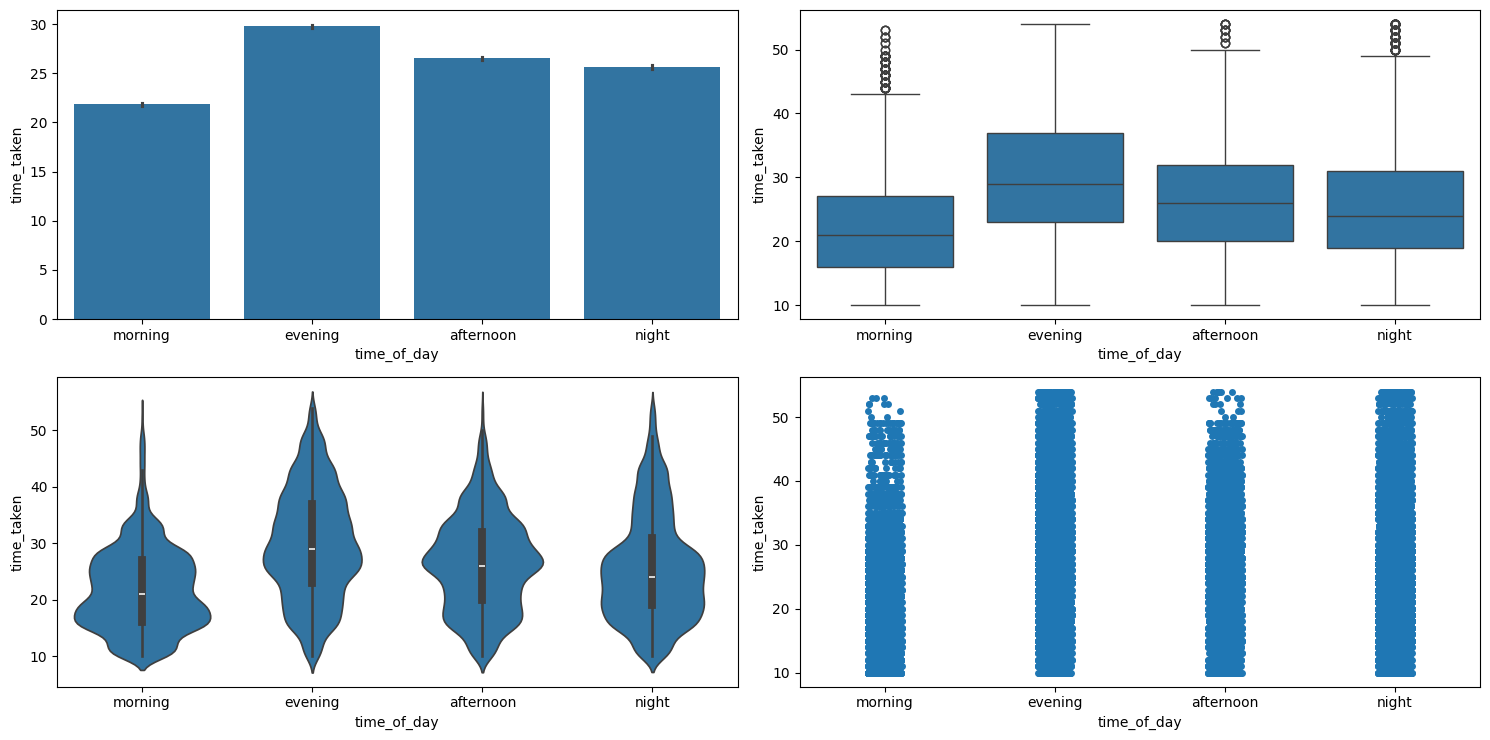

In [64]:
# does time of day affects delivery times

numerical_categorical_analysis(clean_df, "time_of_day", "time_taken")

In [65]:
# relationship between time of day and traffic

chi_2_test(clean_df, "time_of_day", "traffic")

0.0
Reject the null hypothesis. There is a significant association between time_of_day and traffic.


In [66]:
# anova test

anova_test(clean_df, "time_taken", "time_of_day")

0.0
Reject the null hypothesis. There is a significant relationship between time_taken and time_of_day.


In [67]:
# Top 5 times(hrs) of the day in which customers  order the most

clean_df["order_time_hour"].value_counts().head(5)

order_time_hour
21.0    4686
19.0    4595
22.0    4576
20.0    4539
23.0    4511
Name: count, dtype: int64

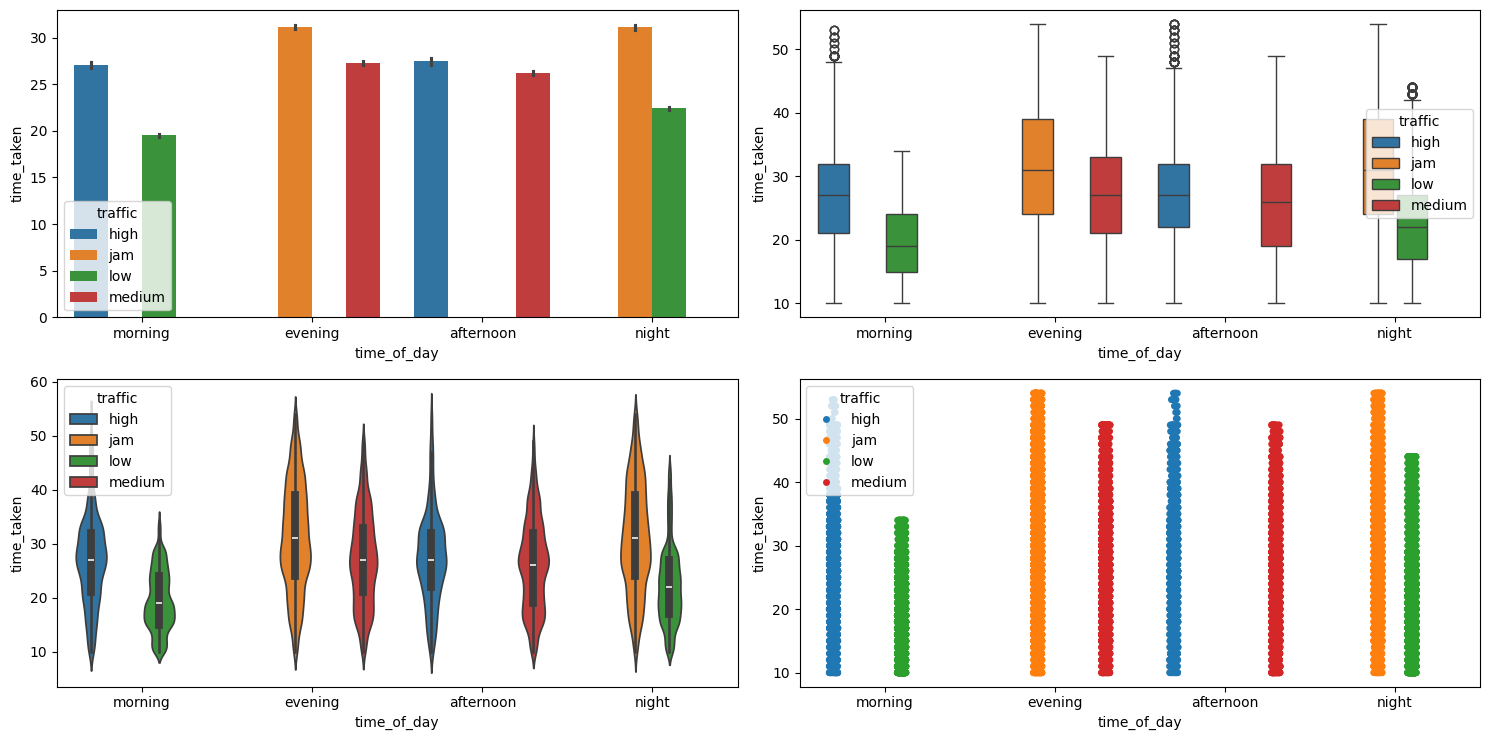

In [68]:
# can delivery time be affected by both time of day and traffic

multivariate_analysis(clean_df, "time_taken", "time_of_day", "traffic")

Count Percentage
order_time_hour                  
21.0              4686     10.68%
19.0              4595     10.48%
22.0              4576     10.43%
20.0              4539     10.35%
23.0              4511     10.28%
18.0              4480     10.21%
17.0              4278      9.75%
10.0              1991      4.54%
11.0              1962      4.47%
9.0               1947      4.44%
8.0               1818      4.14%
12.0               892      2.03%
15.0               873      1.99%
14.0               791       1.8%
13.0               784      1.79%
16.0               709      1.62%
0.0                430      0.98%

**************************************************
The unique categories in order_time_hour column are [11.0, 19.0, 8.0, 18.0, 13.0, 21.0, 17.0, 20.0, 14.0, 9.0, 22.0, 12.0, 23.0, nan, 10.0, 16.0, 15.0, 0.0]
**************************************************
The number of categories in order_time_hour column are 17


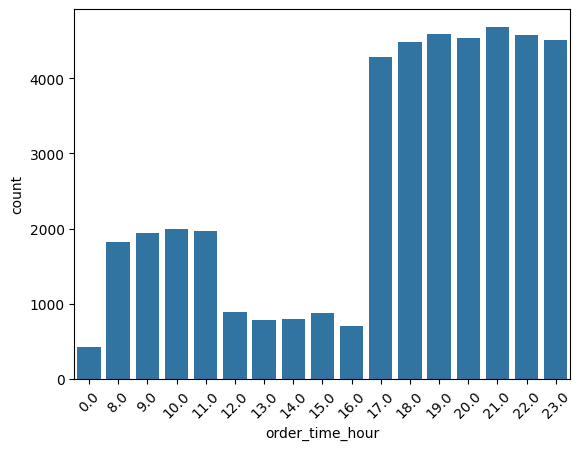

In [69]:
# categorical analysis on order_time_hour

categorical_analysis(clean_df, "order_time_hour")

Count Percentage
time_of_day                  
night        13773     31.71%
evening      13614     31.35%
morning       8610     19.82%
afternoon     7435     17.12%

**************************************************
The unique categories in time_of_day column are ['morning', 'evening', 'afternoon', 'night', nan]
**************************************************
The number of categories in time_of_day column are 4


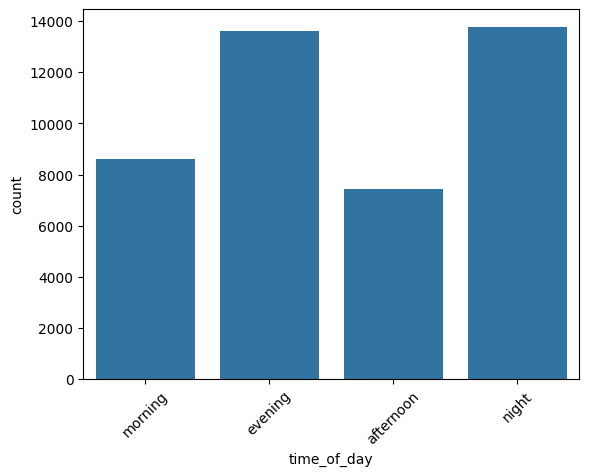

In [70]:
# categorical analysis on time of day

categorical_analysis(clean_df, "time_of_day")

#### Pickup time

In [71]:
# pickup_time datatype

clean_df['pickup_time_minutes'].dtype

dtype('float64')

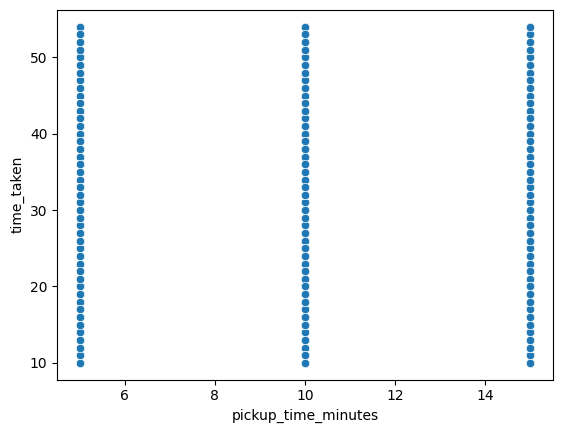

In [72]:
# relationship between pickup time and delivery time

sns.scatterplot(clean_df, x = "pickup_time_minutes", y = "time_taken")
plt.show()

 **Convert the column to ordinal categorical column**

Count Percentage
pickup_time_minutes                  
5.0                  14703     33.52%
15.0                 14610     33.31%
10.0                 14549     33.17%

**************************************************
The unique categories in pickup_time_minutes column are [15.0, 5.0, 10.0, nan]
**************************************************
The number of categories in pickup_time_minutes column are 3


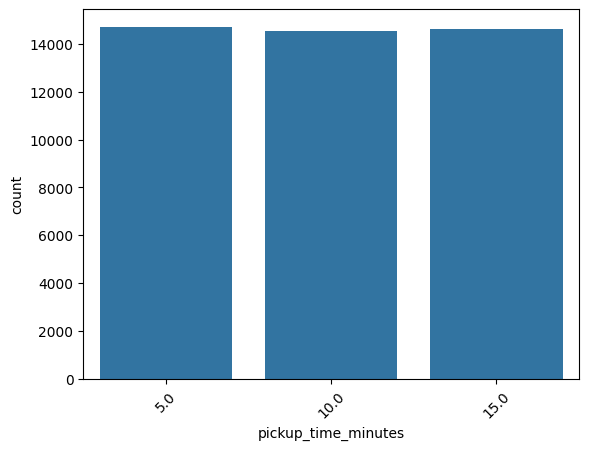

In [73]:
# pickup time categorical analysis

categorical_analysis(clean_df, "pickup_time_minutes")

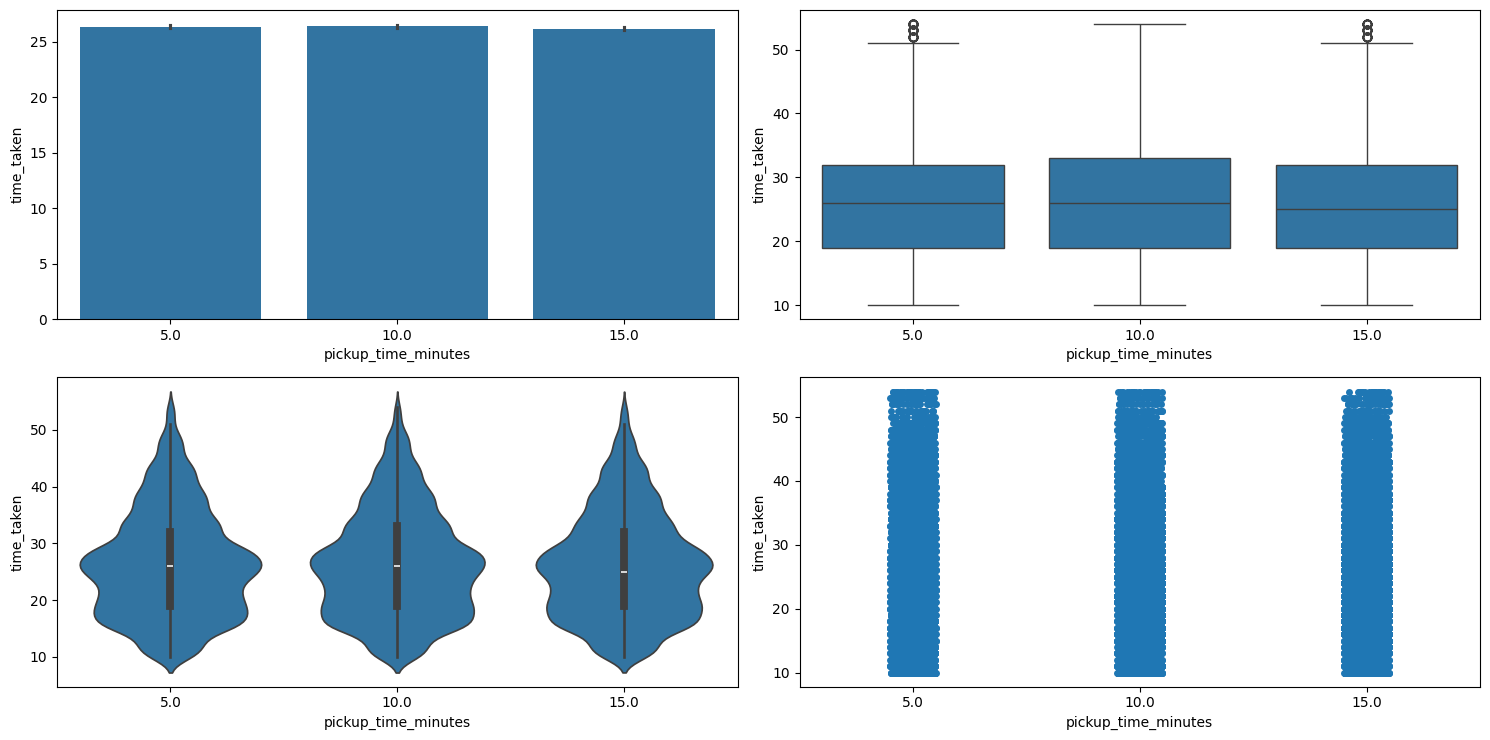

In [74]:
# does pickup time have an effect on delivery time

numerical_categorical_analysis(clean_df, "pickup_time_minutes", "time_taken")

In [75]:
# hypothesis testing to prove point

anova_test(clean_df, "time_taken", "pickup_time_minutes")

0.09932647028954891
Fail to reject the null hypothesis. There is no significant relationship between time_taken and pickup_time_minutes.


#### Traffic

In [76]:
# datatype of traffic column

clean_df['traffic'].dtype

dtype('O')

Count Percentage
traffic                  
low      15477      34.4%
jam      14143     31.43%
medium   10947     24.33%
high      4425      9.84%

**************************************************
The unique categories in traffic column are ['high', 'jam', 'low', 'medium', nan]
**************************************************
The number of categories in traffic column are 4


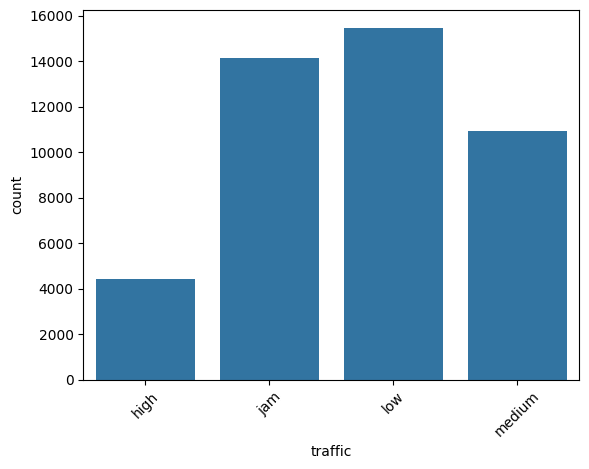

In [77]:
# categorical analysis on traffic

categorical_analysis(clean_df, "traffic")

In [78]:
# does traffic depends on type of city

chi_2_test(clean_df, "traffic", "city_type")

2.3390790568495405e-104
Reject the null hypothesis. There is a significant association between traffic and city_type.


In [79]:
# does traffic depends on city

chi_2_test(clean_df, "traffic", "extracted_city")

0.4978080180955253
Fail to reject the null hypothesis. There is no significant association between traffic and extracted_city.


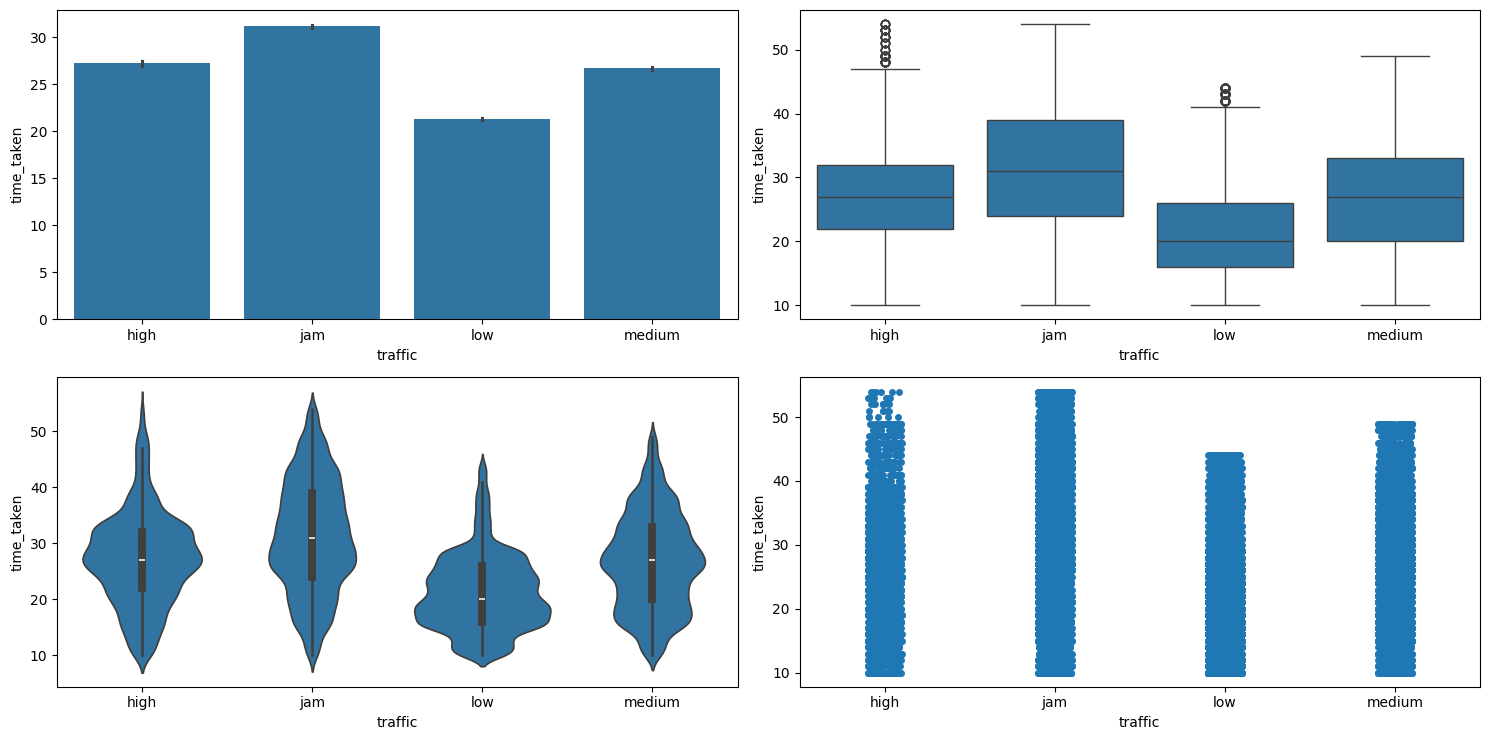

In [80]:
# does traffic affects delivery times

numerical_categorical_analysis(clean_df, "traffic", "time_taken")

In [81]:
# hypothesis test on does traffic affects delivery times

anova_test(clean_df, "time_taken", "traffic")

0.0
Reject the null hypothesis. There is a significant relationship between time_taken and traffic.


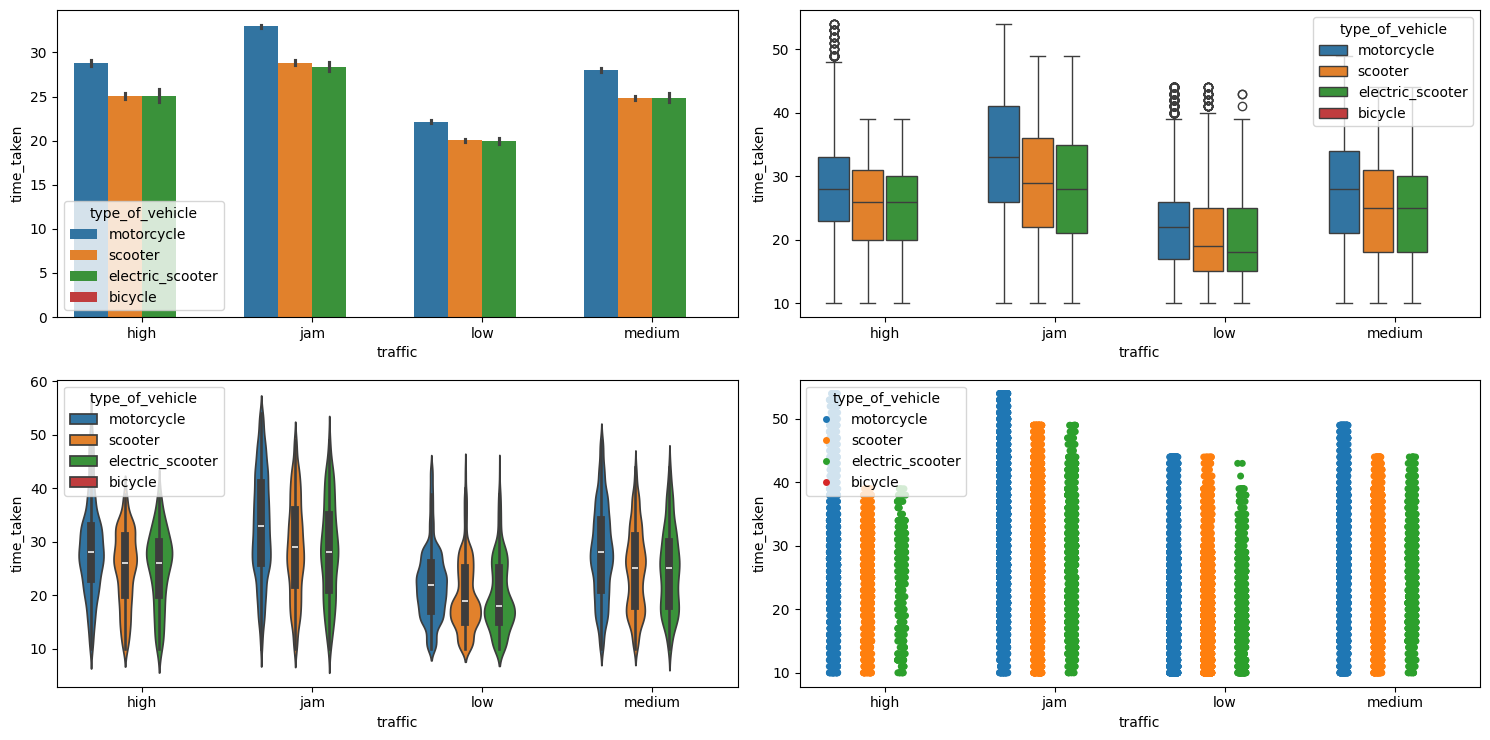

In [82]:
# are some vehicle types more suitable in traffic than others

multivariate_analysis(clean_df, "time_taken", "traffic", "type_of_vehicle")

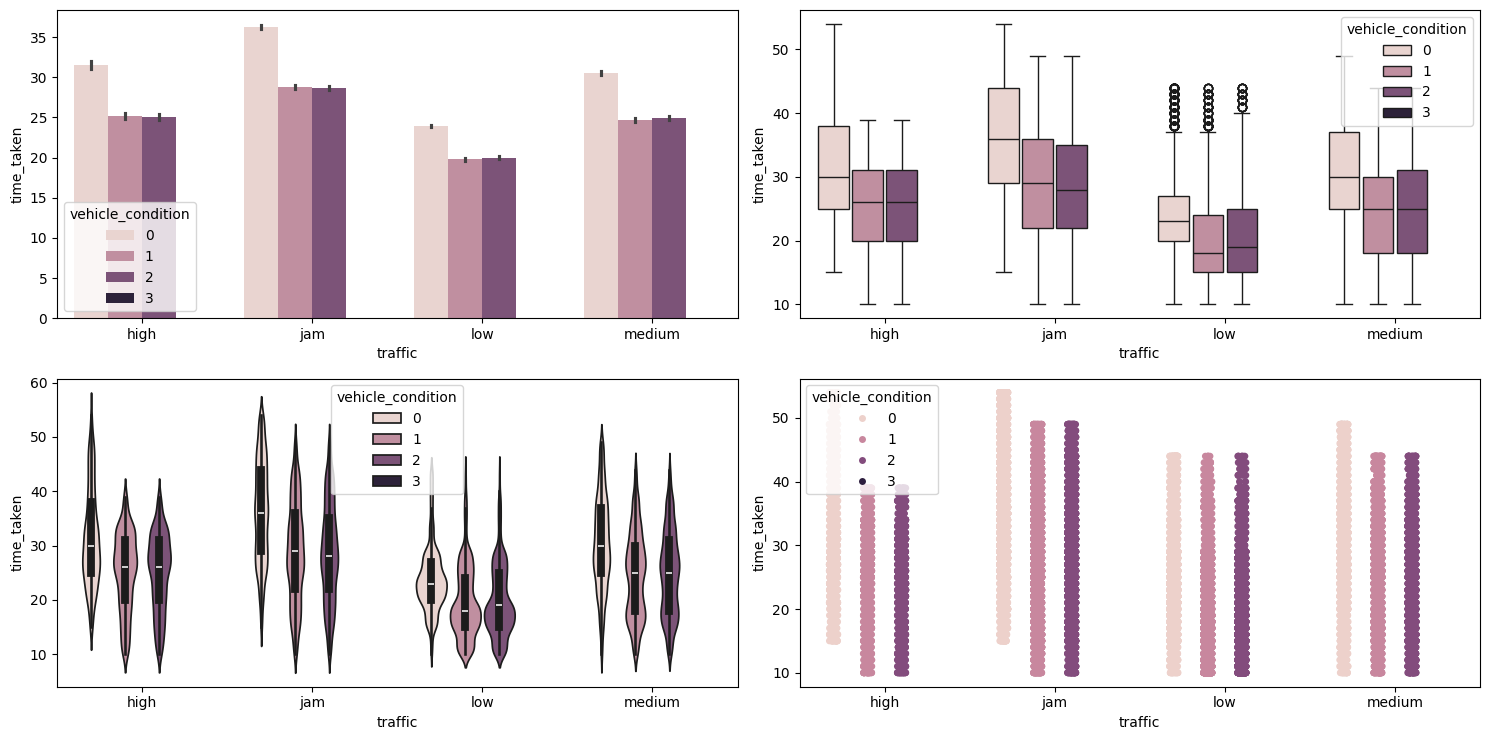

In [83]:
# does vehicle condition in traffic situations affects delivery times

multivariate_analysis(clean_df, "time_taken", "traffic", "vehicle_condition")

**Dont make wrong interpretations that good condition vehicles takes longer times on avg**

This simply means that good vehicles are preferred for deliveries during festivals which results in longer delivery times

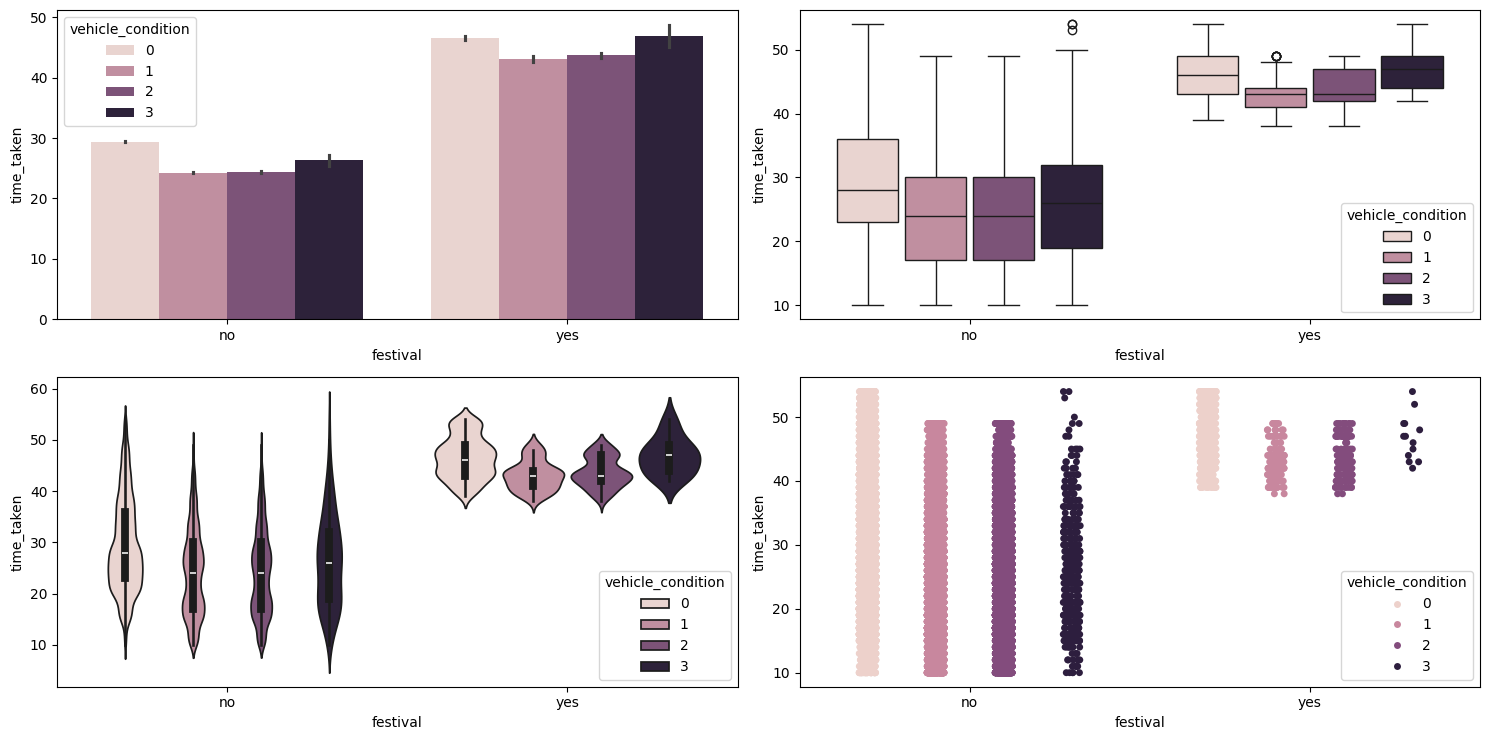

In [84]:
multivariate_analysis(clean_df, "time_taken", "festival", "vehicle_condition")

#### Multiple deliveries

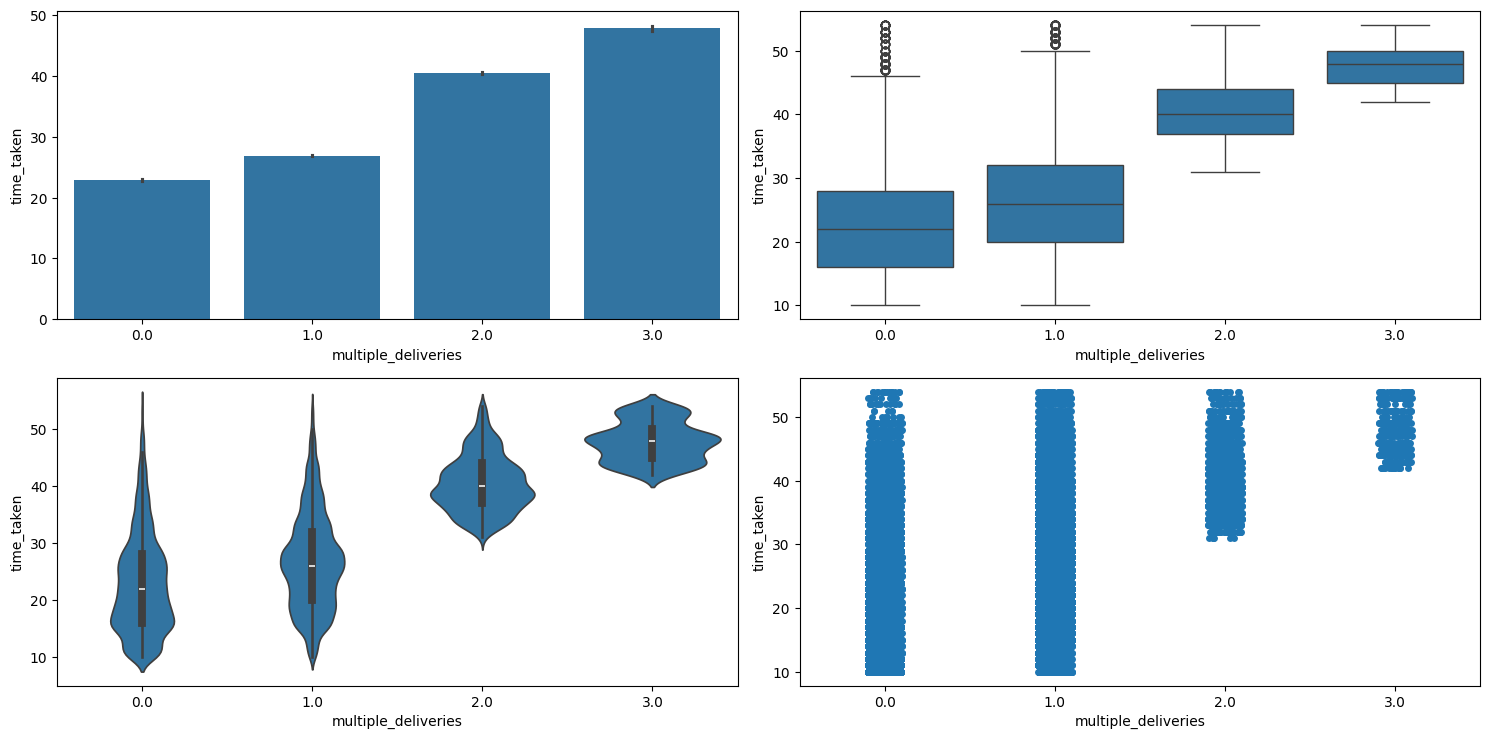

In [85]:
# does multiple delivereis affect delivery times

numerical_categorical_analysis(clean_df, "multiple_deliveries", "time_taken")

In [86]:
# hypothesis test

anova_test(clean_df, "time_taken", "multiple_deliveries")

0.0
Reject the null hypothesis. There is a significant relationship between time_taken and multiple_deliveries.


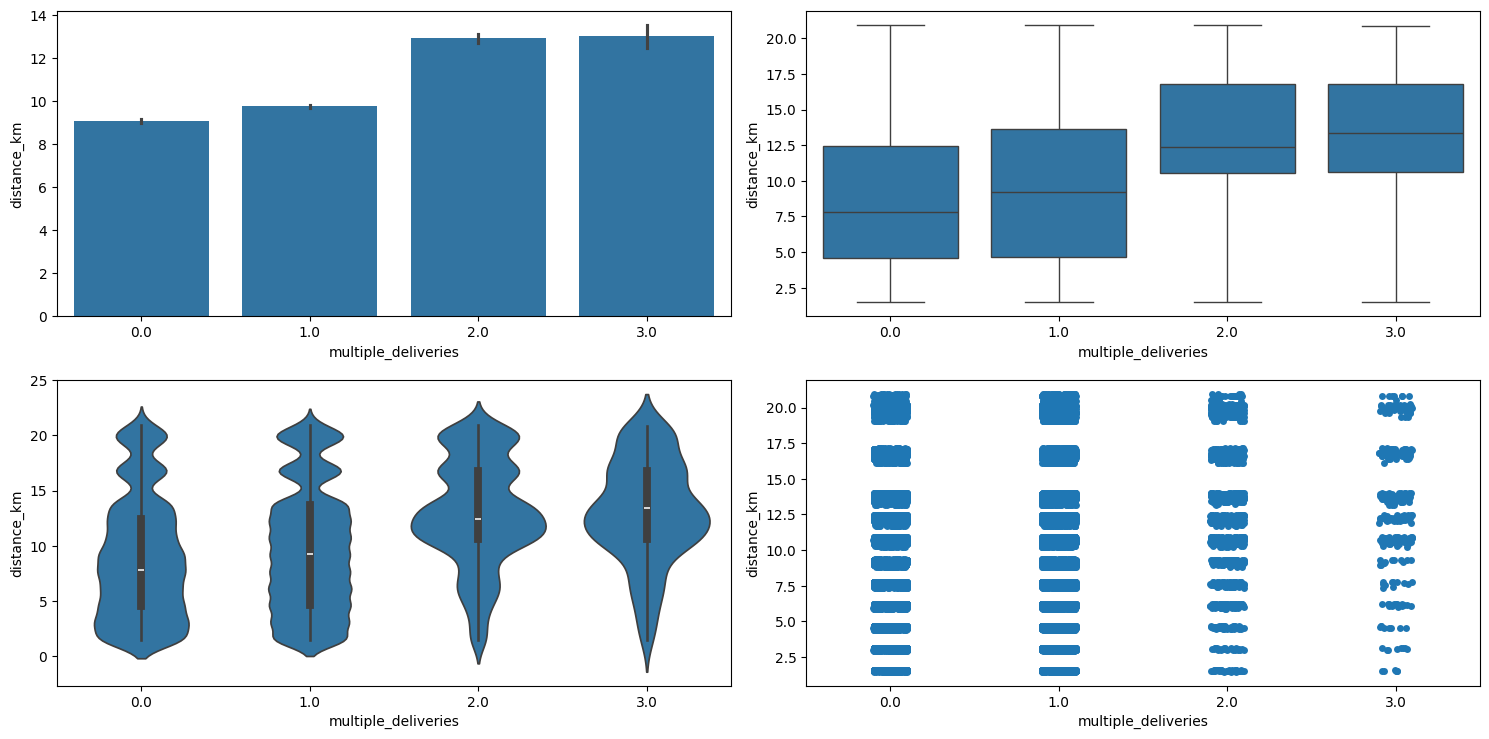

In [87]:
# do multiple deliveries are of longer distances

numerical_categorical_analysis(clean_df, "multiple_deliveries", "distance_km")

#### Weather

In [88]:
# data type of weather column

clean_df['weather'].dtype

dtype('O')

Count Percentage
weather                     
fog          7654     17.02%
stormy       7586     16.87%
cloudy       7536     16.76%
sandstorms   7495     16.66%
windy        7422      16.5%
sunny        7284     16.19%

**************************************************
The unique categories in weather column are ['sunny', 'stormy', 'sandstorms', 'cloudy', 'fog', 'windy', nan]
**************************************************
The number of categories in weather column are 6


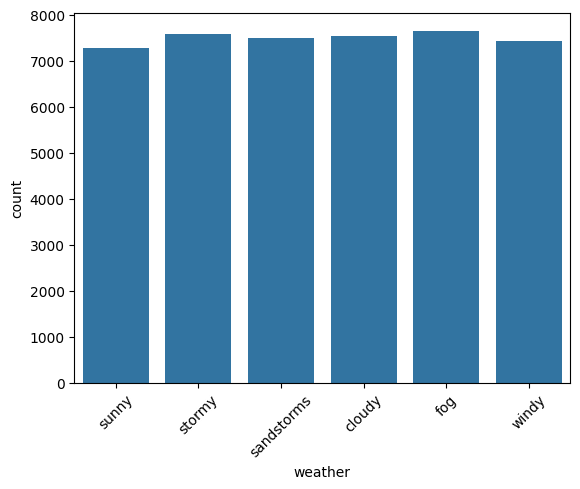

In [89]:
# categorical analysis on type of weather

categorical_analysis(clean_df, "weather")

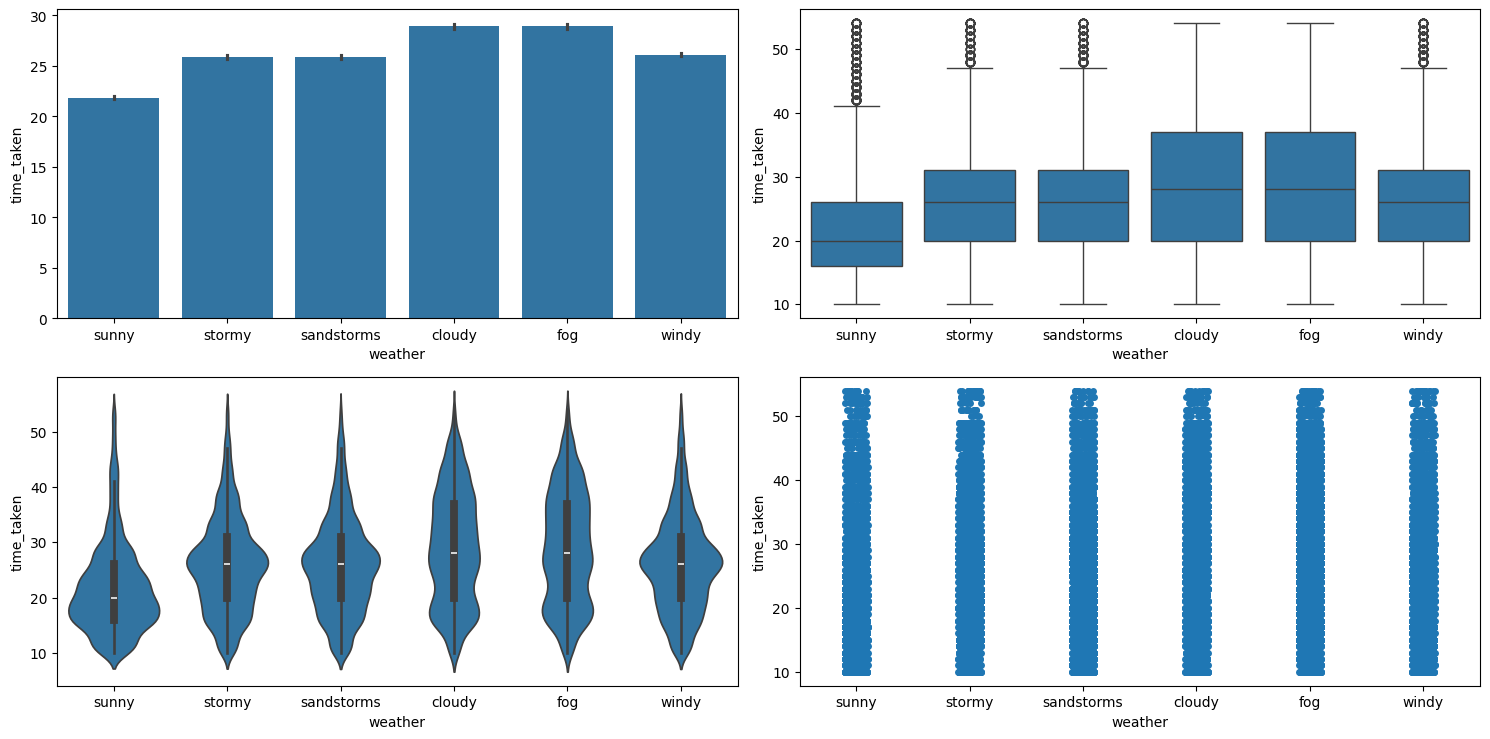

In [90]:
# does weather affect delivery times

numerical_categorical_analysis(clean_df, "weather", "time_taken")

In [91]:
# hypothesis test

anova_test(clean_df, "time_taken", "weather")

0.0
Reject the null hypothesis. There is a significant relationship between time_taken and weather.


In [92]:
# does the weather affects traffic

chi_2_test(clean_df, "weather", "traffic")

0.4796388074753828
Fail to reject the null hypothesis. There is no significant association between weather and traffic.


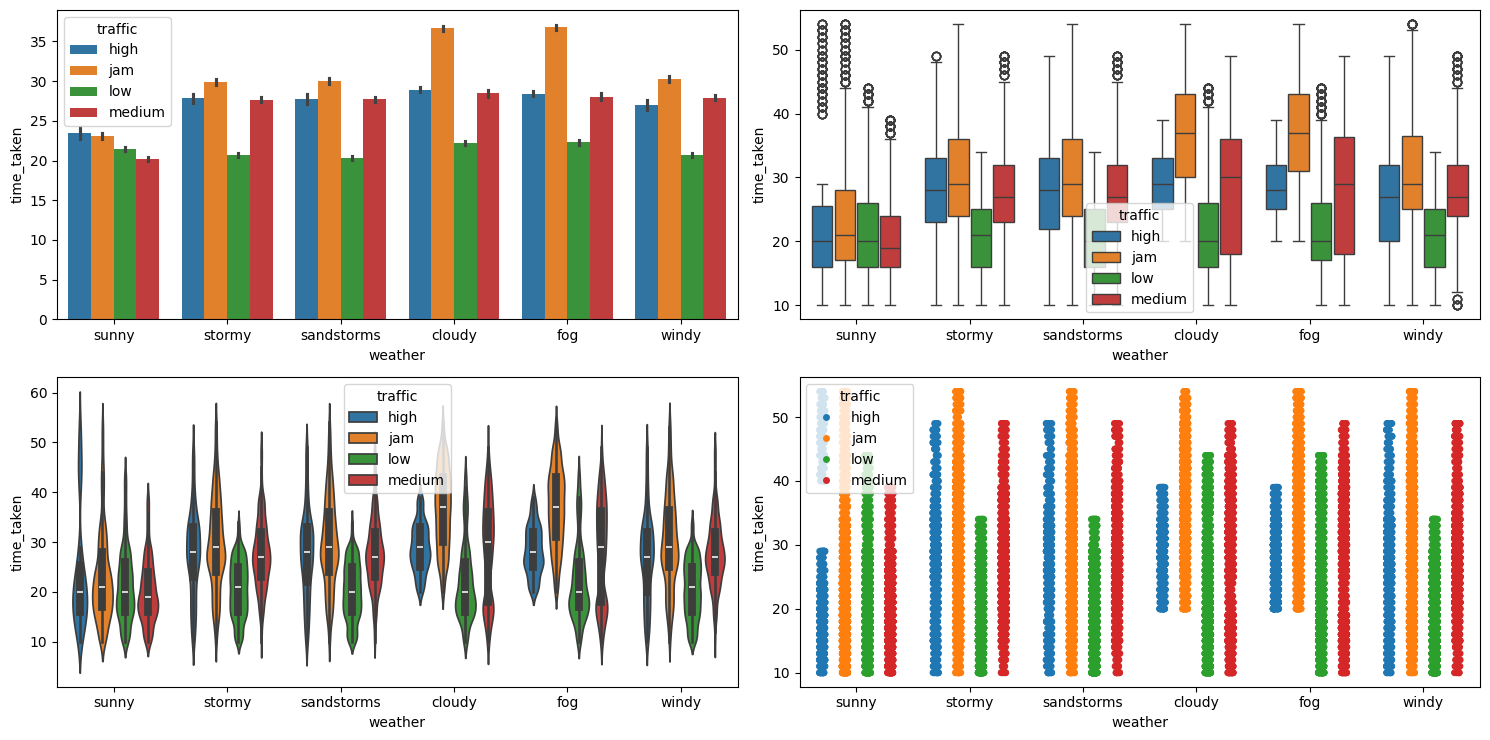

In [93]:
# delivery times based on weather and traffic

multivariate_analysis(clean_df, "time_taken", "weather", "traffic")

**Seems like traffic along with other features combined acts as great discriminatory feature**

In [94]:
# pivot table

clean_df.pivot_table(index="weather",columns="traffic",values="time_taken",aggfunc="mean")

traffic          high        jam        low     medium
weather                                               
cloudy      28.940860  36.689655  22.208445  28.483134
fog         28.426546  36.806916  22.303427  28.044816
sandstorms  27.711840  30.018758  20.297049  27.738522
stormy      27.845839  29.850194  20.681734  27.680502
sunny       23.448980  23.082132  21.449293  20.195518
windy       26.972789  30.219056  20.665862  27.888769

#### Vehicle condition and type

Count Percentage
vehicle_condition                  
2                  15034     33.04%
1                  15030     33.03%
0                  15009     32.99%
3                    429      0.94%

**************************************************
The unique categories in vehicle_condition column are [2, 0, 1, 3]
**************************************************
The number of categories in vehicle_condition column are 4


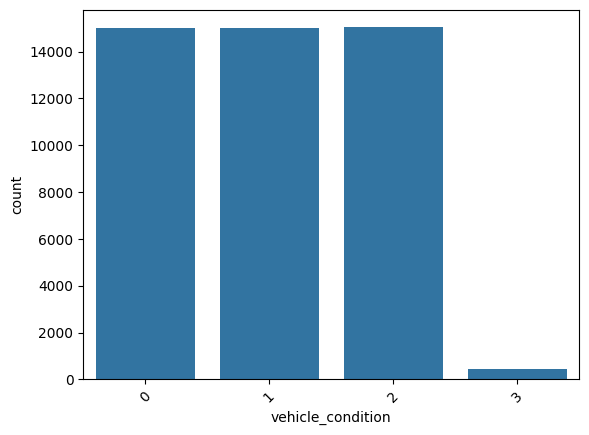

In [95]:
# categorical analysis on vehicle condition

categorical_analysis(clean_df, "vehicle_condition")

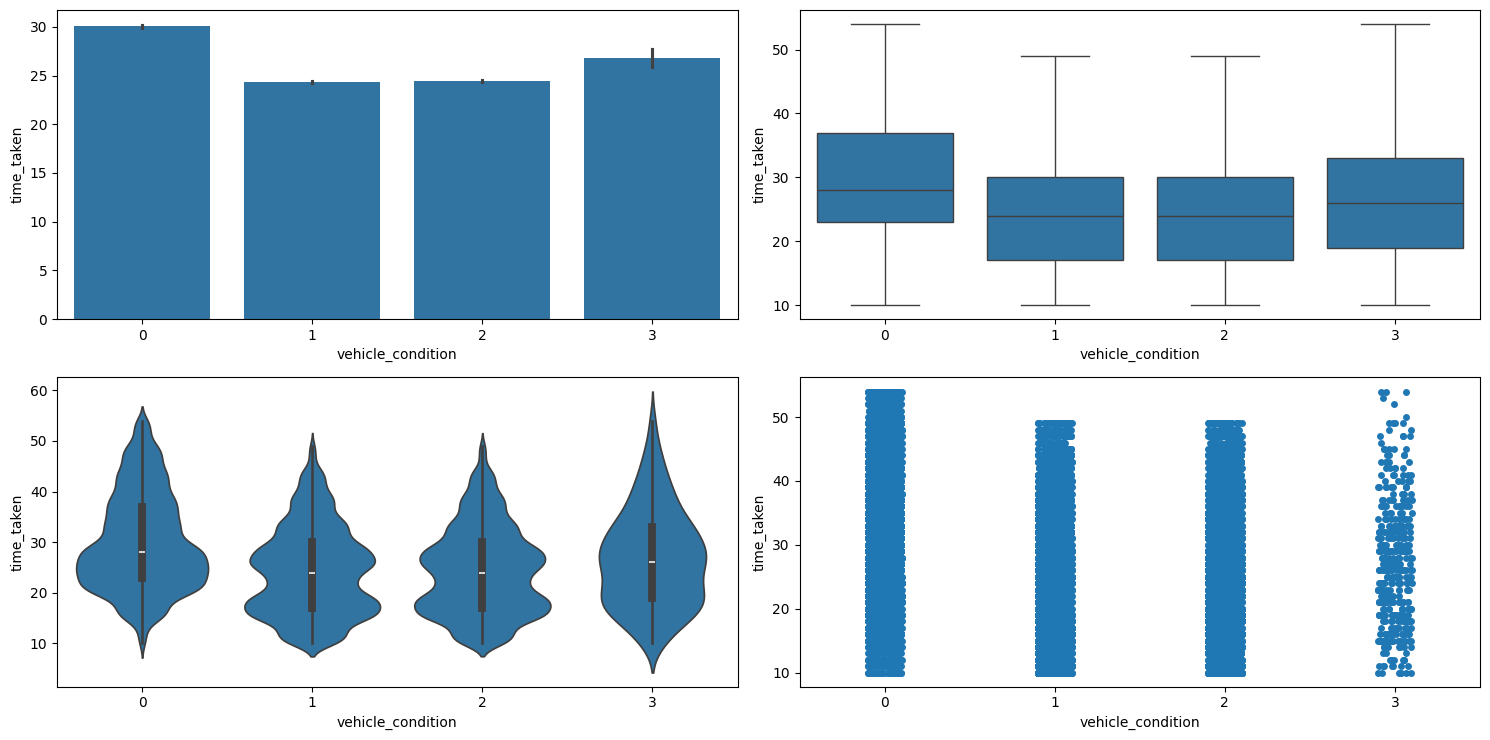

In [96]:
# does vehicle condition affect delivery times

numerical_categorical_analysis(clean_df, "vehicle_condition", "time_taken")

In [97]:
# anova test

anova_test(clean_df, "time_taken", "vehicle_condition")

0.0
Reject the null hypothesis. There is a significant relationship between time_taken and vehicle_condition.


Count Percentage
type_of_vehicle                   
motorcycle        26427     58.08%
scooter           15244      33.5%
electric_scooter   3778       8.3%
bicycle              53      0.12%

**************************************************
The unique categories in type_of_vehicle column are ['motorcycle', 'scooter', 'electric_scooter', 'bicycle']
**************************************************
The number of categories in type_of_vehicle column are 4


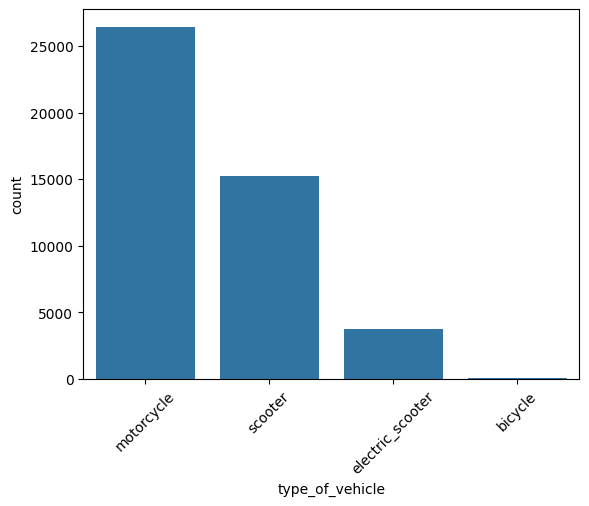

In [98]:
# analysis on vehicle type

categorical_analysis(clean_df, "type_of_vehicle")

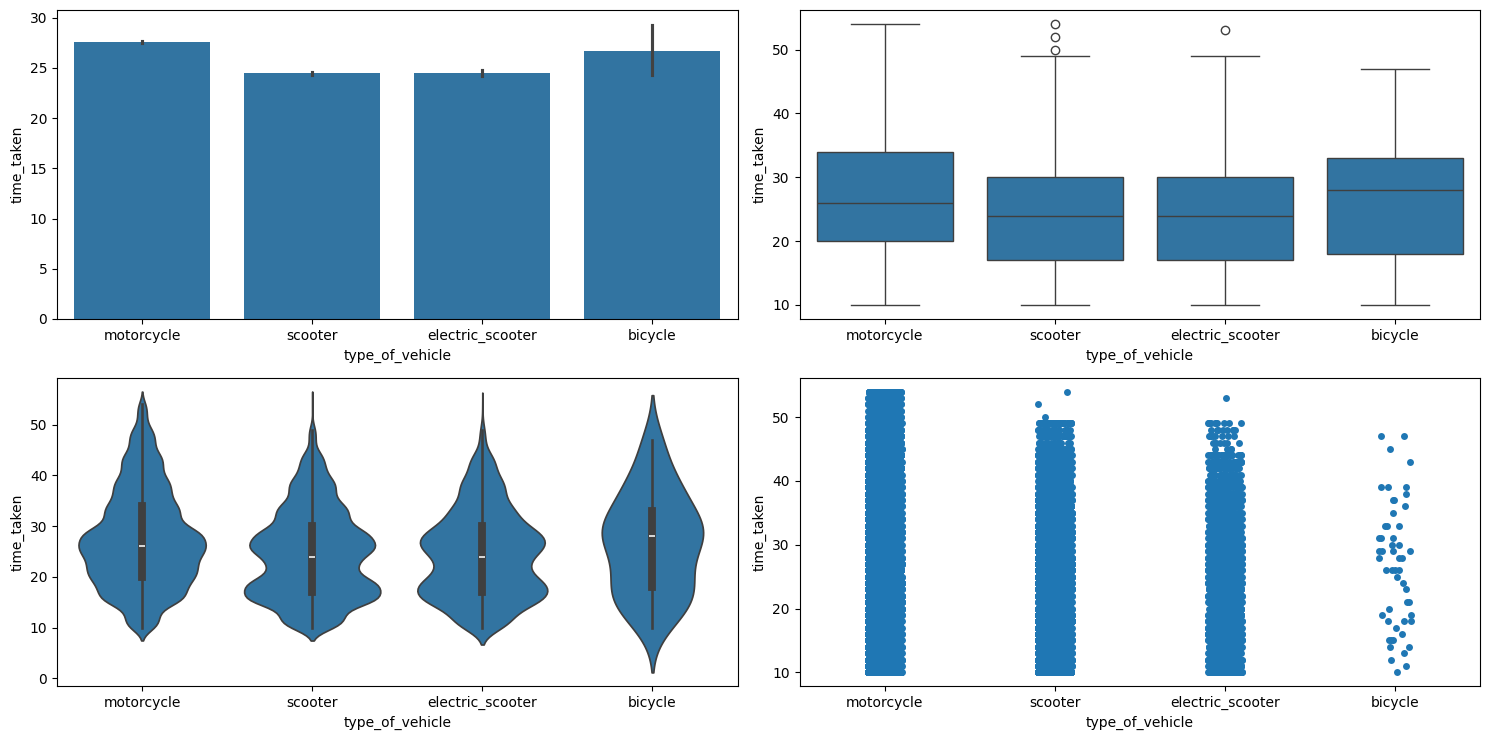

In [99]:
# does the type of vehicle affects delivery time

numerical_categorical_analysis(clean_df, "type_of_vehicle", "time_taken")

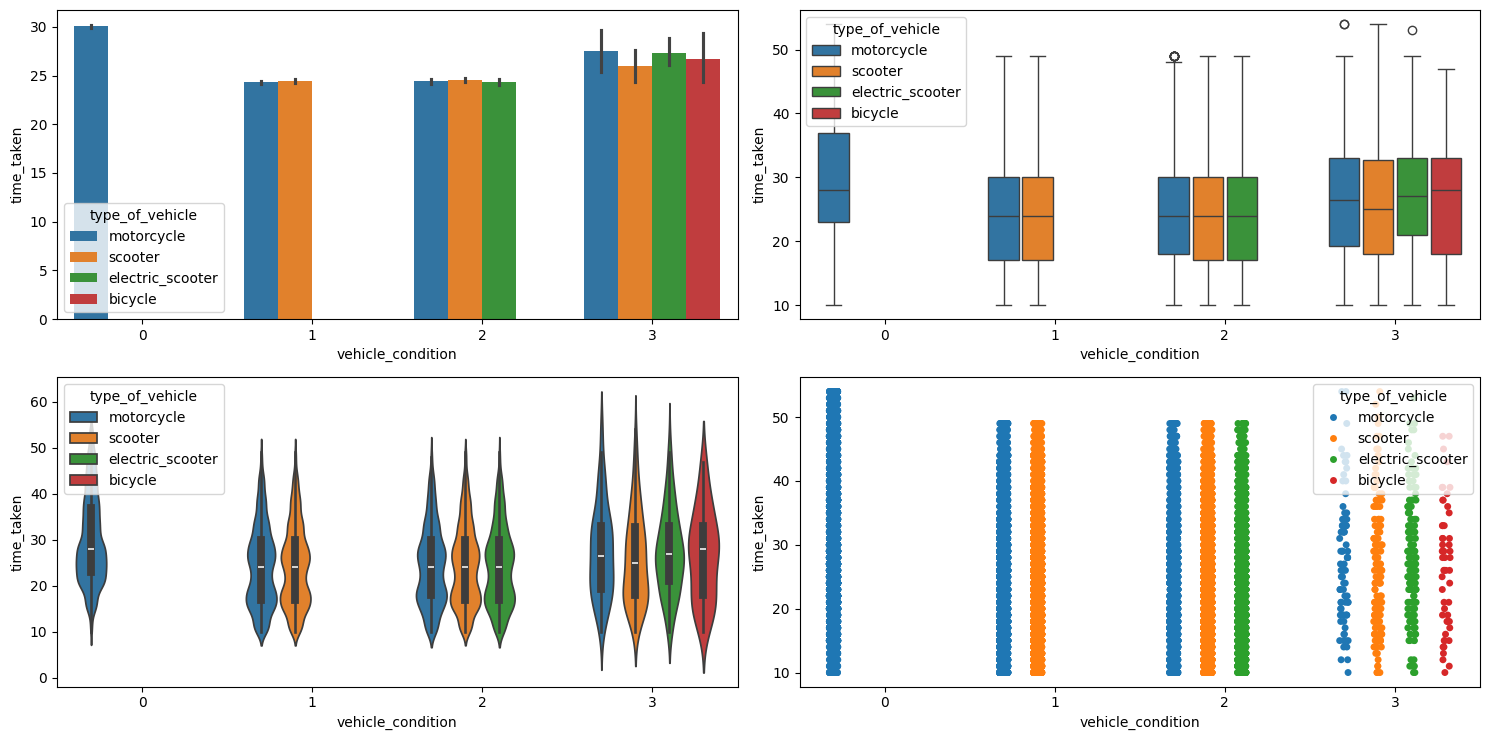

In [100]:
# vehicle condition and type

multivariate_analysis(clean_df, "time_taken", "vehicle_condition", "type_of_vehicle")

In [101]:
# is their a relation between vehicle type and conditions

chi_2_test(clean_df, "type_of_vehicle", "vehicle_condition")

0.0
Reject the null hypothesis. There is a significant association between type_of_vehicle and vehicle_condition.


#### Type of order

In [102]:
# type of order dtype

clean_df['type_of_order'].dtype

dtype('O')

Count Percentage
type_of_order                  
snack          11512      25.3%
meal           11435     25.13%
drinks         11294     24.82%
buffet         11261     24.75%

**************************************************
The unique categories in type_of_order column are ['snack', 'drinks', 'buffet', 'meal']
**************************************************
The number of categories in type_of_order column are 4


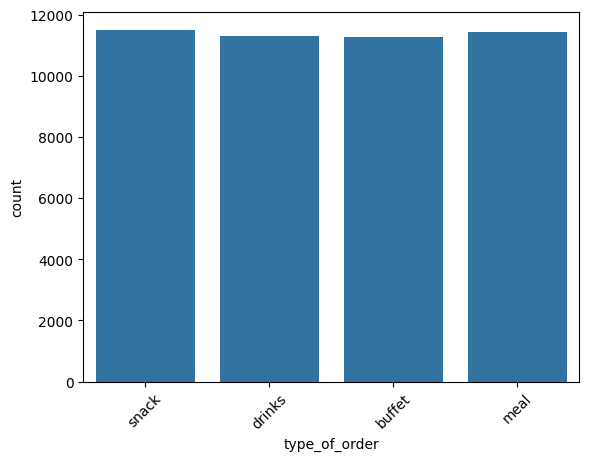

In [103]:
# analysis on type of order

categorical_analysis(clean_df, "type_of_order")

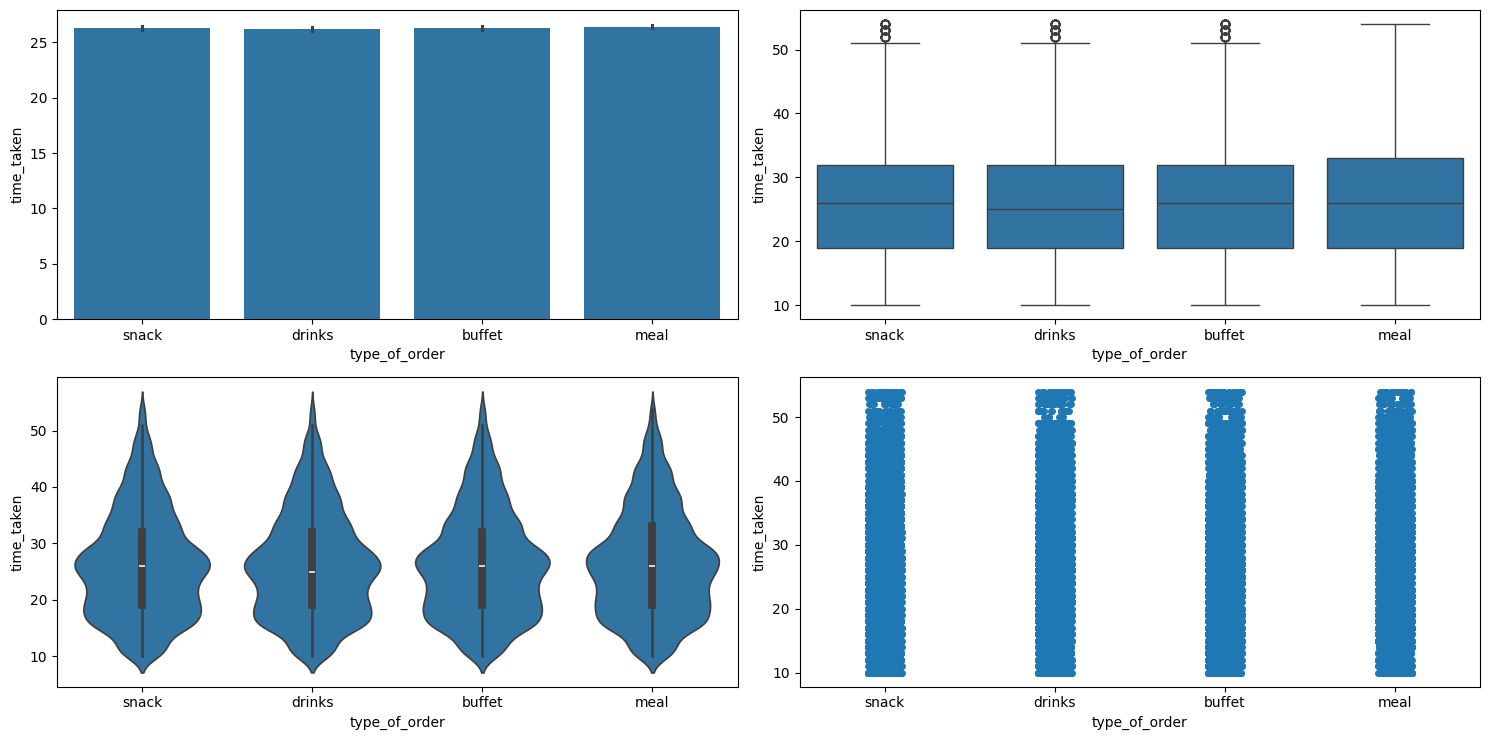

In [104]:
# does order type have have effect on delivery times

numerical_categorical_analysis(clean_df, "type_of_order", "time_taken")

In [105]:
# hypothesis test

anova_test(clean_df, "time_taken", "type_of_order")

0.3043309877239704
Fail to reject the null hypothesis. There is no significant relationship between time_taken and type_of_order.


In [106]:
# contingency table

pd.crosstab(clean_df["type_of_order"],clean_df["order_is_weekend"])

order_is_weekend     0     1
type_of_order               
buffet            8238  3023
drinks            8130  3164
meal              8290  3145
snack             8337  3175

In [107]:
# does type of order have an effect over pickup time

chi_2_test(clean_df,"pickup_time_minutes","type_of_order")

0.49118080317709845
Fail to reject the null hypothesis. There is no significant association between pickup_time_minutes and type_of_order.


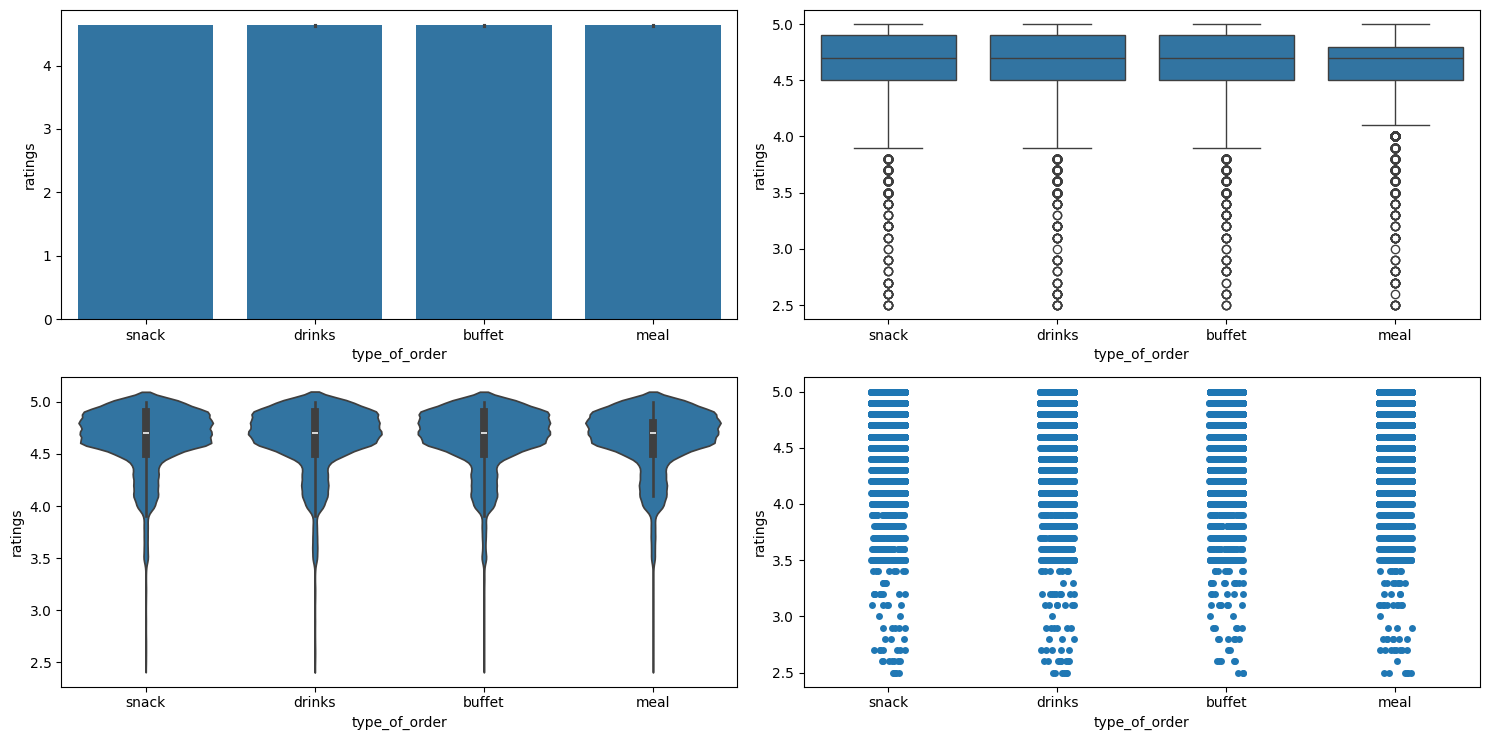

In [108]:
# does order type has an effect on ratings

numerical_categorical_analysis(clean_df, "type_of_order", "ratings")

In [109]:
# is their a relationship between weekends and type of order

chi_2_test(clean_df, "order_is_weekend", "type_of_order")

0.2658161540207276
Fail to reject the null hypothesis. There is no significant association between order_is_weekend and type_of_order.


In [110]:
# is their a relationship between festivals and type of order

chi_2_test(clean_df, "festival", "type_of_order")

0.6149018072722126
Fail to reject the null hypothesis. There is no significant association between festival and type_of_order.


#### Extracted city name

Count Percentage
extracted_city                  
JAP              3439      7.56%
RANCHI           3222      7.08%
BANG             3184       7.0%
SUR              3182      6.99%
HYD              3177      6.98%
MUM              3168      6.96%
MYS              3164      6.95%
COIMB            3162      6.95%
VAD              3159      6.94%
INDO             3154      6.93%
CHEN             3132      6.88%
PUNE             3129      6.88%
AGR               761      1.67%
LUDH              758      1.67%
ALH               738      1.62%
KNP               737      1.62%
DEH               735      1.62%
GOA               709      1.56%
AURG              703      1.54%
KOC               701      1.54%
KOL               699      1.54%
BHP               689      1.51%

**************************************************
The unique categories in extracted_city column are ['INDO', 'BANG', 'COIMB', 'CHEN', 'HYD', 'RANCHI', 'MYS', 'DEH', 'KOC', 'PUNE', 'LUDH', 'KNP', 'MUM', 'KOL', 'JAP', 'SUR', 'GOA', 'AURG', 'AGR', 'VAD', 'ALH', 'BHP']
**************************************************
The number of categories in extracted_city column are 22


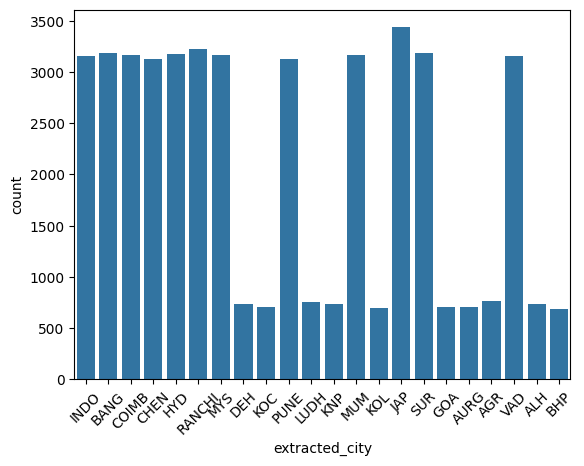

In [111]:
# categorical analysis on city name

categorical_analysis(clean_df, "extracted_city")

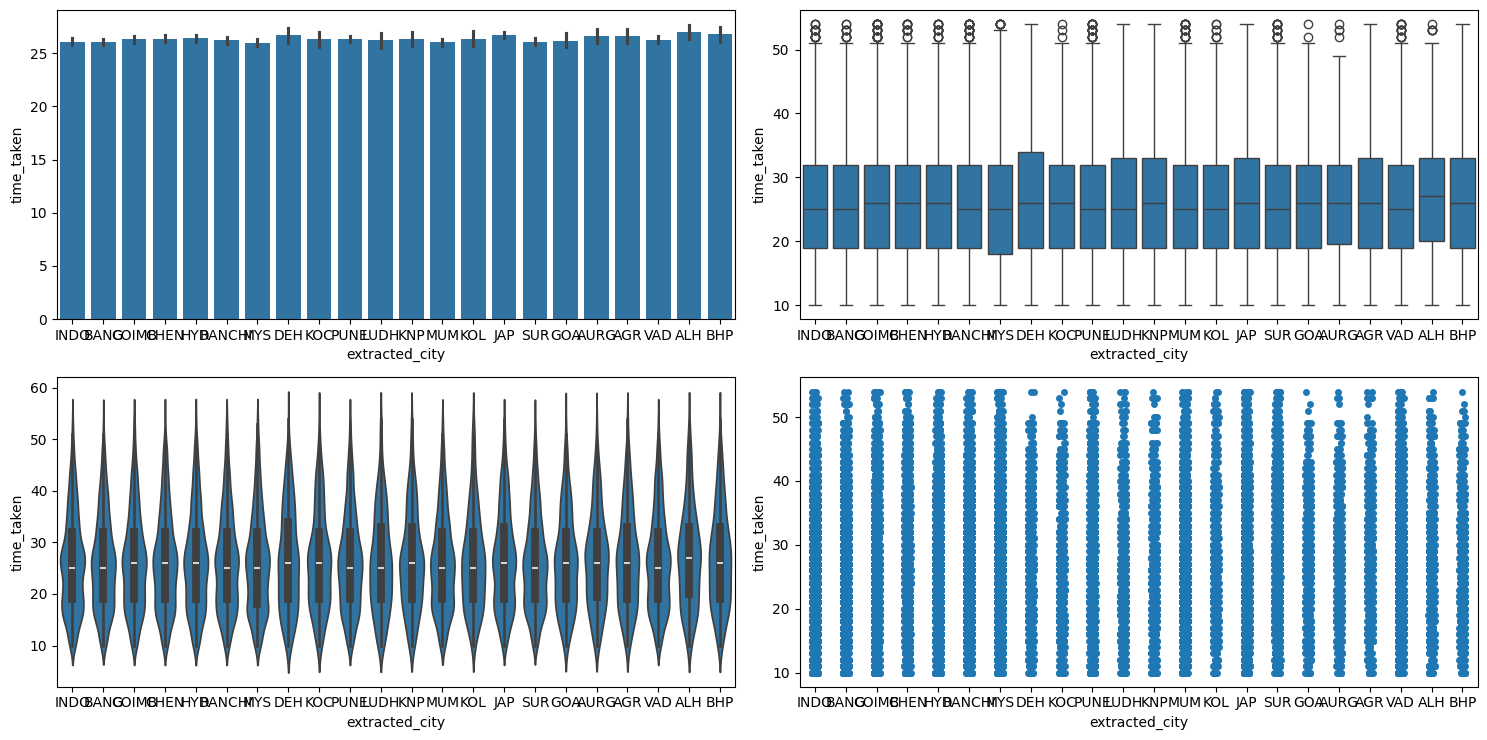

In [112]:
# does a city affects delivery times

numerical_categorical_analysis(clean_df, "extracted_city", "time_taken")

Count Percentage
city_type                      
metropolitian  34029     76.81%
urban          10111     22.82%
semi-urban       164      0.37%

**************************************************
The unique categories in city_type column are ['urban', 'metropolitian', 'semi-urban', nan]
**************************************************
The number of categories in city_type column are 3


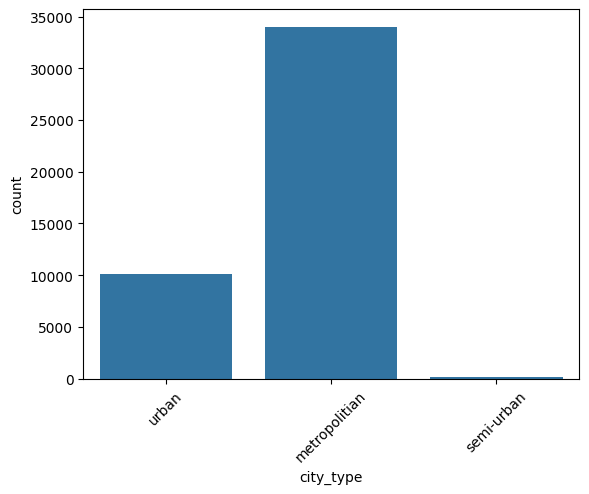

In [113]:
# categorical analysis on city type

categorical_analysis(clean_df, "city_type")

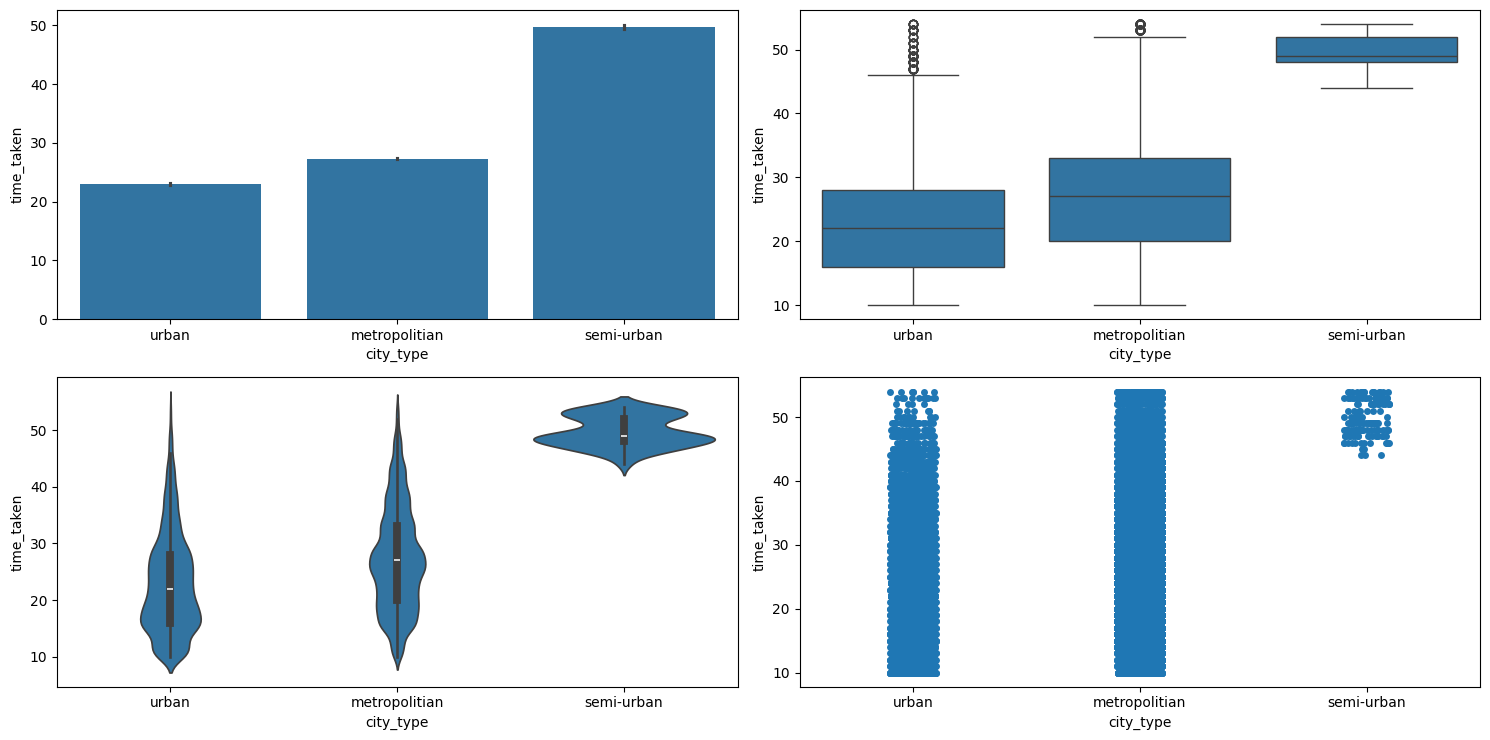

In [114]:
# does city types affect delivery times

numerical_categorical_analysis(clean_df, "city_type", "time_taken")

In [115]:
# hypothesis test

anova_test(clean_df, "time_taken", "city_type")

0.0
Reject the null hypothesis. There is a significant relationship between time_taken and city_type.


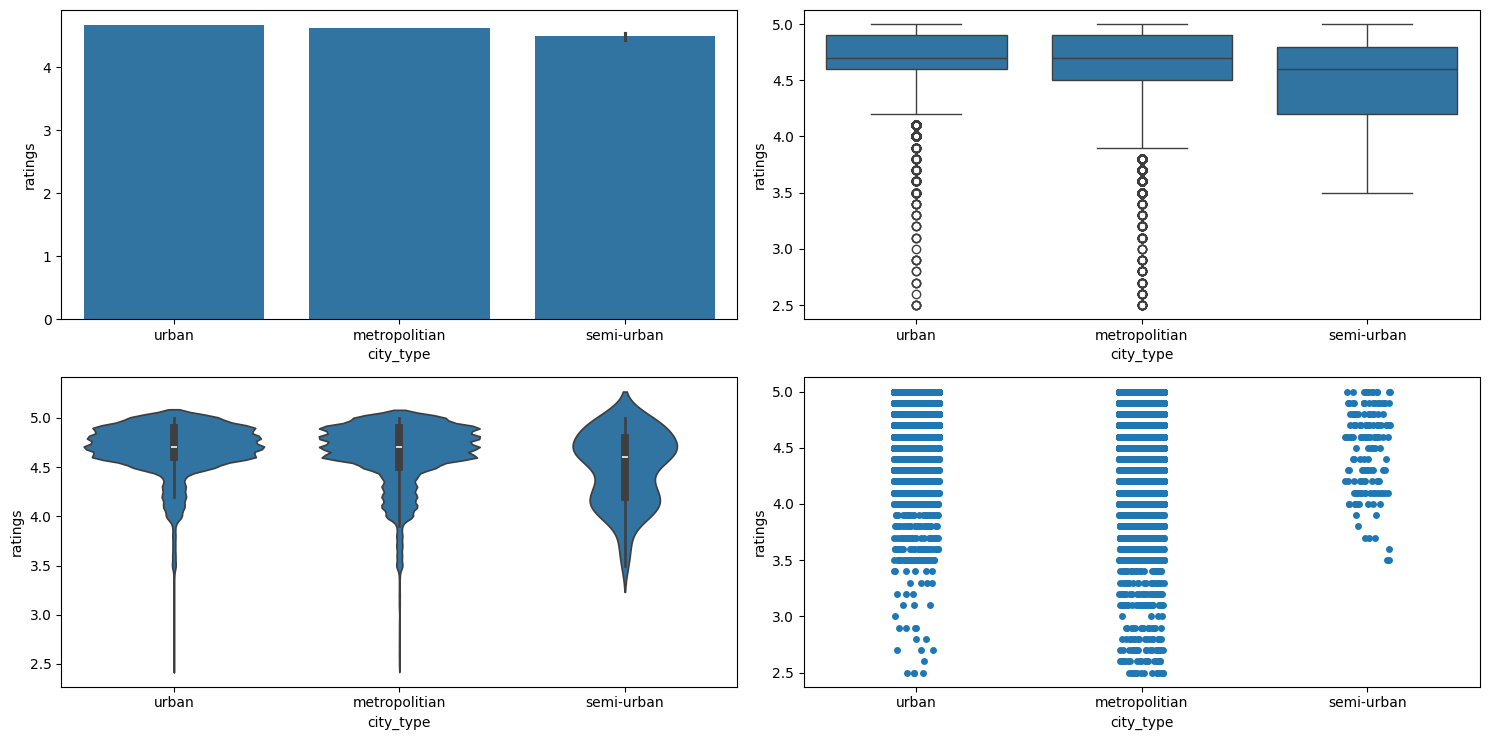

In [116]:
# does city type affects rider ratings

numerical_categorical_analysis(clean_df, "city_type", "ratings")

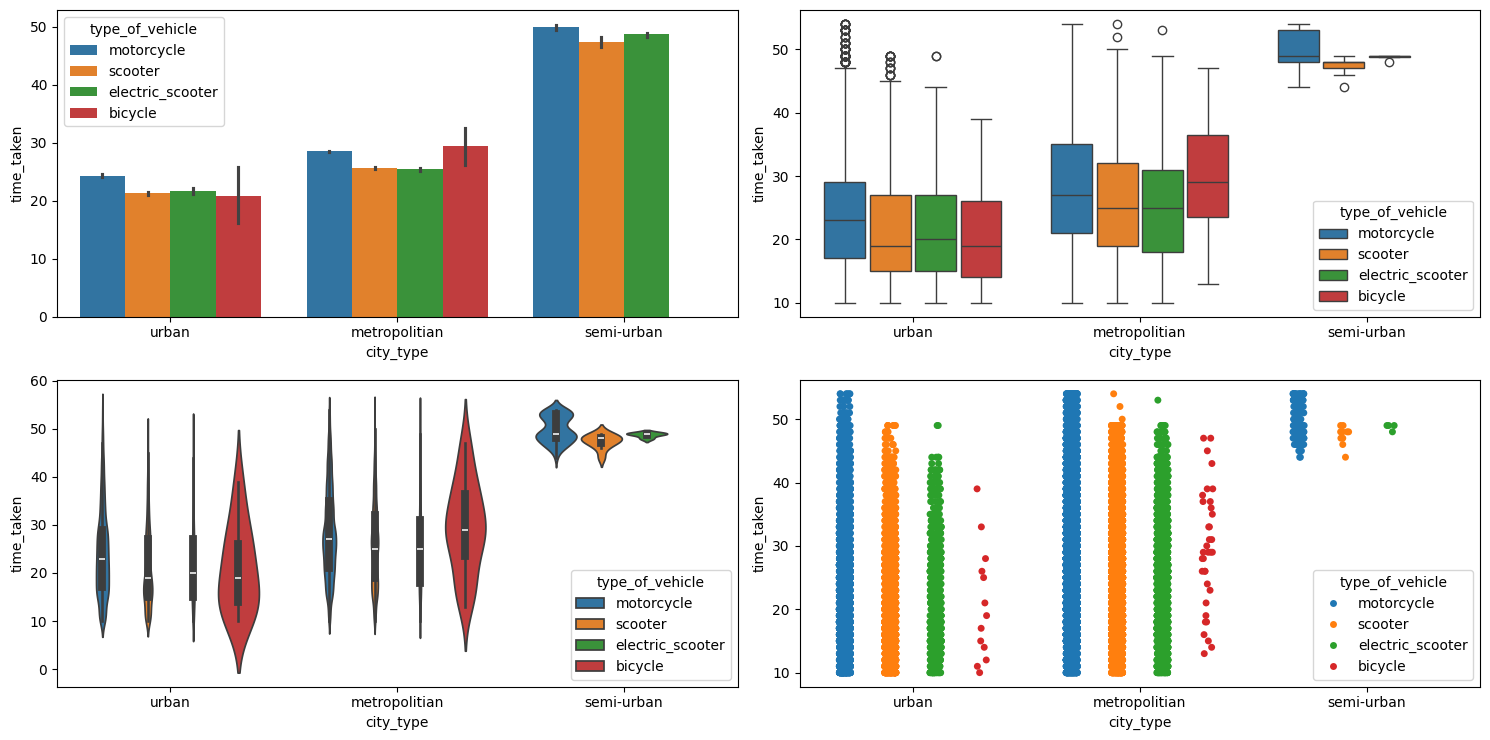

In [117]:
# city type, type of vehicle and delivery time analysis

multivariate_analysis(clean_df, "time_taken", "city_type", "type_of_vehicle")

#### Distance

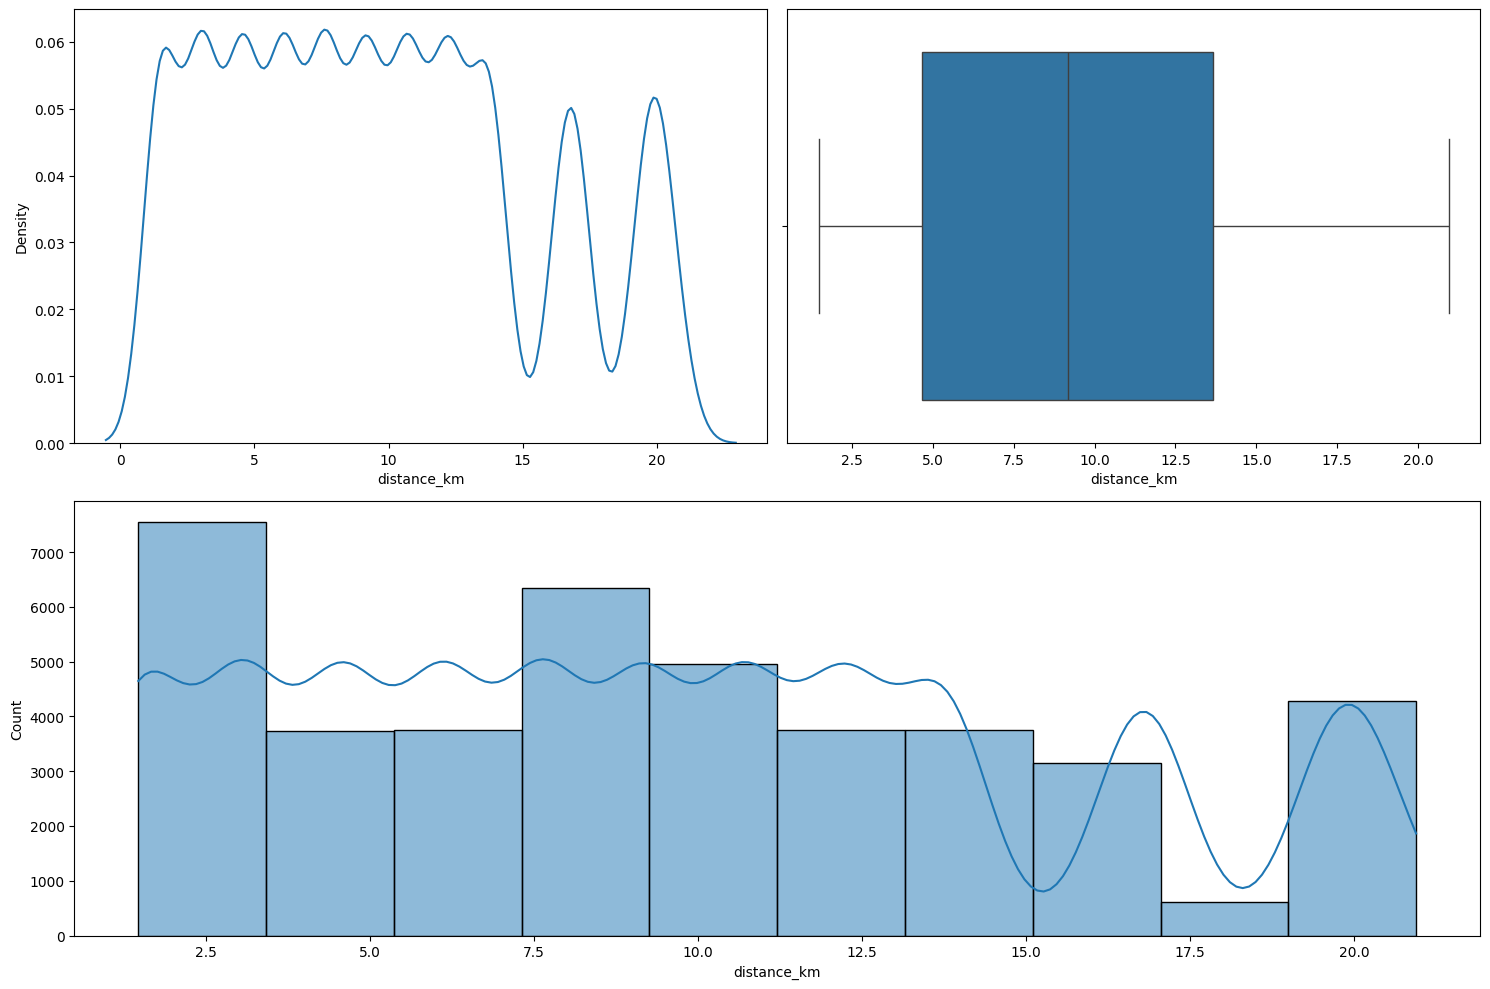

In [118]:
# numerical analysis of distance

numerical_analysis(clean_df, "distance_km",bins=10)

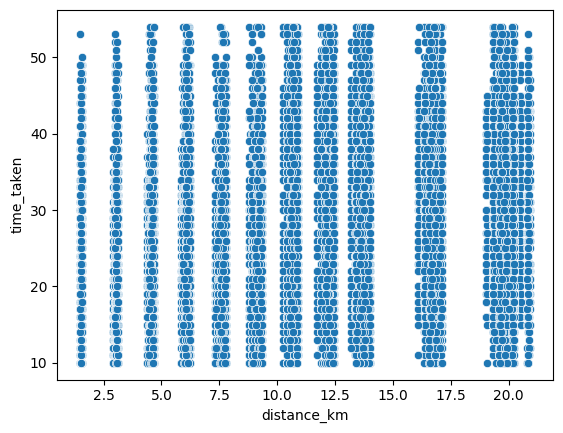

In [119]:
# relationship between distance and delivery times

sns.scatterplot(clean_df,x="distance_km",y="time_taken")
plt.show()

In [120]:
# corr

clean_df[["distance_km","time_taken"]].corr()

distance_km  time_taken
distance_km     1.000000    0.320706
time_taken      0.320706    1.000000

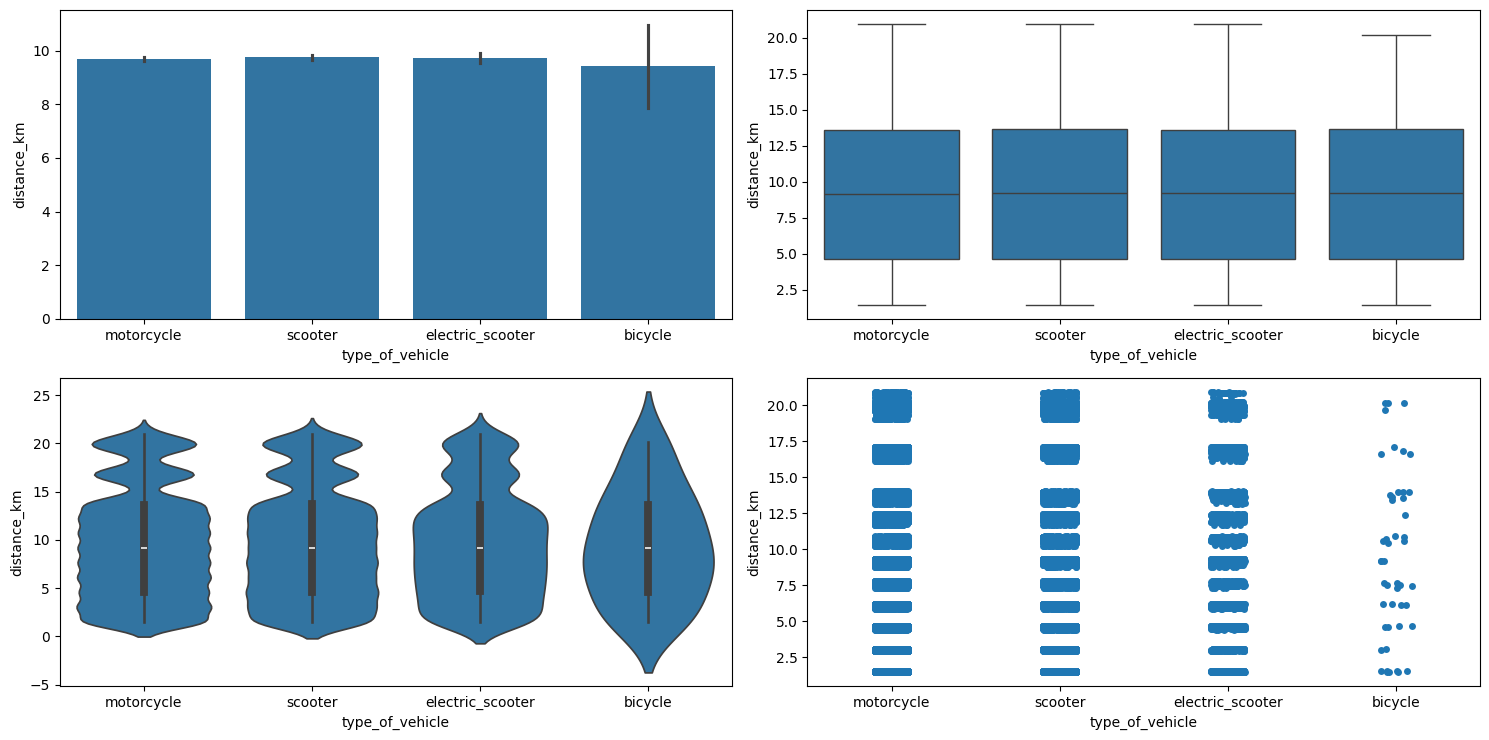

In [121]:
# vehicle type and distance analysis

numerical_categorical_analysis(clean_df, "type_of_vehicle", "distance_km")

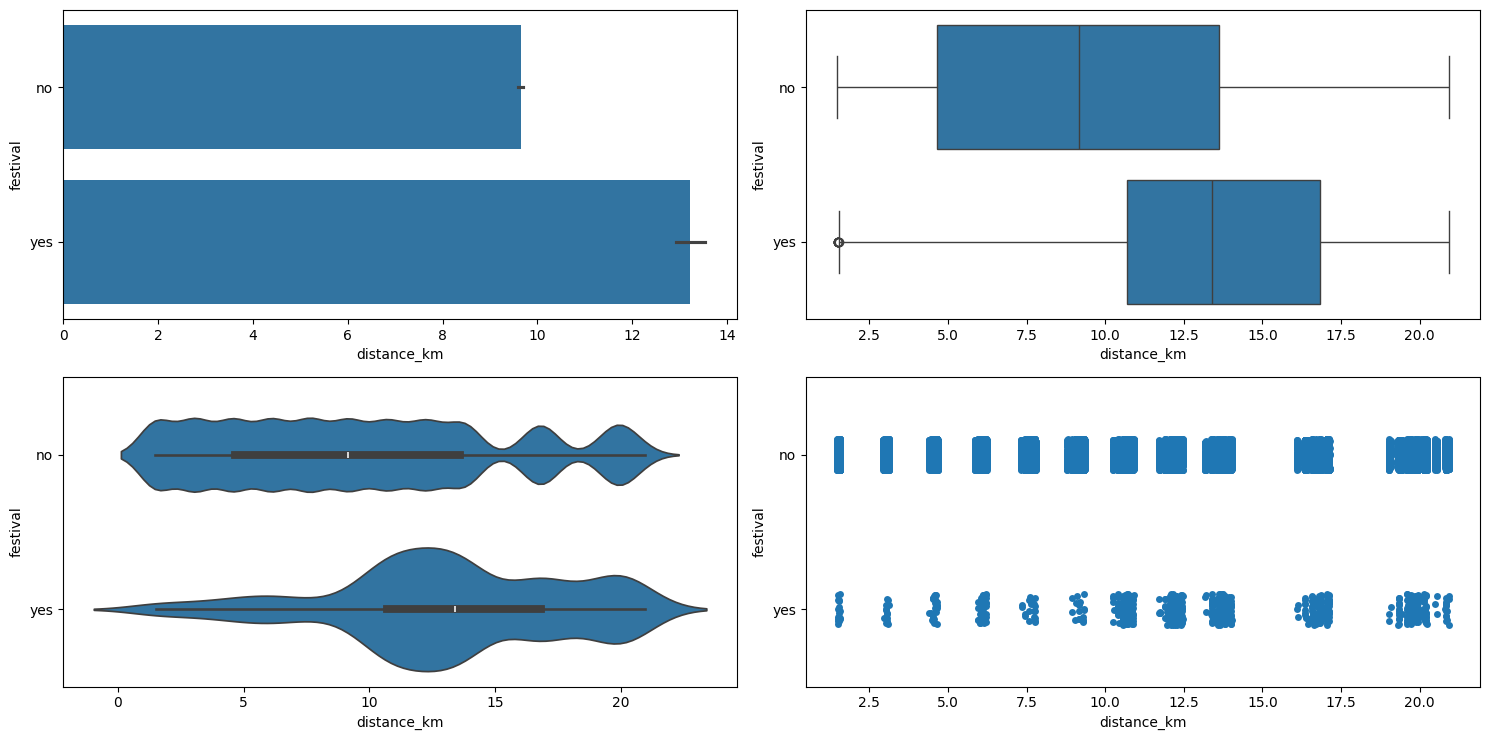

In [122]:
# do riders cover more distances during festivals

numerical_categorical_analysis(clean_df, "distance_km", "festival")

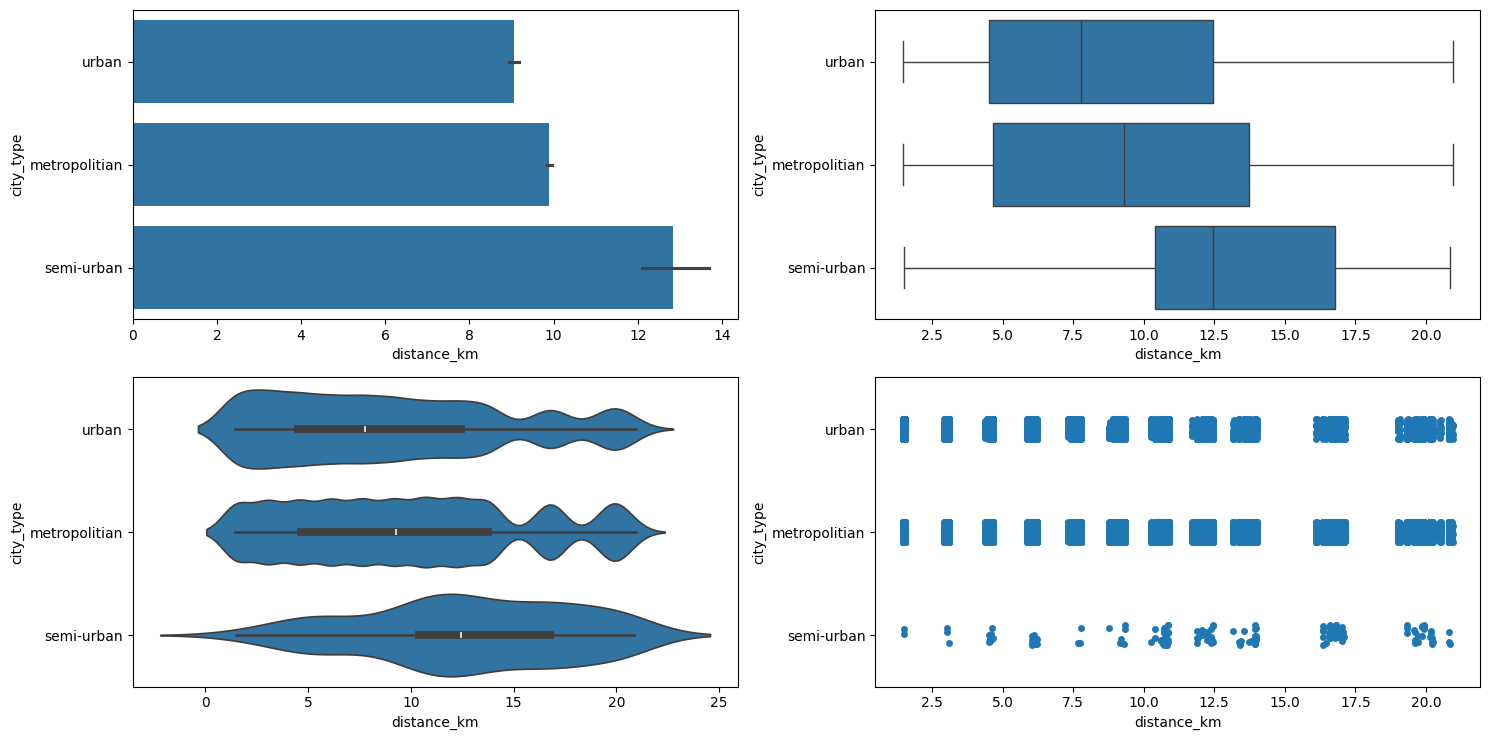

In [123]:
# distance and city type

numerical_categorical_analysis(clean_df, "distance_km", "city_type")

In [124]:
# new feature based on distance

clean_df = clean_df.assign(
                        distance_type = pd.cut(clean_df["distance_km"],bins=[0,5,10,15,25],
                                               right=False,labels=["short","medium","long","very_long"])
                                    )

In [125]:
clean_df

rider_id   age  ratings  restaurant_latitude  \
0        INDORES13DEL02   37.0      4.9            22.745049   
1        BANGRES18DEL02   34.0      4.5            12.913041   
2        BANGRES19DEL01   23.0      4.4            12.914264   
3       COIMBRES13DEL02   38.0      4.7            11.003669   
4        CHENRES12DEL01   32.0      4.6            12.972793   
...                  ...   ...      ...                  ...   
45588     JAPRES04DEL01   30.0      4.8            26.902328   
45589     AGRRES16DEL01   21.0      4.6                  NaN   
45590    CHENRES08DEL03   30.0      4.9            13.022394   
45591   COIMBRES11DEL01   20.0      4.7            11.001753   
45592  RANCHIRES09DEL02   23.0      4.9            23.351058   

       restaurant_longitude  delivery_latitude  delivery_longitude  \
0                 75.892471          22.765049           75.912471   
1                 77.683237          13.043041           77.813237   
2                 77.678400          12.924264           77.688400   
3                 76.976494          11.053669           77.026494   
4                 80.249982          13.012793           80.289982   
...                     ...                ...                 ...   
45588             75.794257          26.912328           75.804257   
45589                   NaN                NaN                 NaN   
45590             80.242439          13.052394           80.272439   
45591             76.986241          11.041753           77.026241   
45592             85.325731          23.431058           85.405731   

                order_date     weather traffic  ... order_day order_month  \
0      2022-03-19 00:00:00       sunny    high  ...        19           3   
1      2022-03-25 00:00:00      stormy     jam  ...        25           3   
2      2022-03-19 00:00:00  sandstorms     low  ...        19           3   
3      2022-04-05 00:00:00       sunny  medium  ...         5           4   
4      2022-03-26 00:00:00      cloudy    high  ...        26           3   
...                    ...         ...     ...  ...       ...         ...   
45588  2022-03-24 00:00:00       windy    high  ...        24           3   
45589  2022-02-16 00:00:00       windy     jam  ...        16           2   
45590  2022-03-11 00:00:00      cloudy     low  ...        11           3   
45591  2022-03-07 00:00:00      cloudy    high  ...         7           3   
45592  2022-03-02 00:00:00         fog  medium  ...         2           3   

      order_day_of_week order_is_weekend pickup_time_minutes order_time_hour  \
0              Saturday                1                15.0            11.0   
1                Friday                0                 5.0            19.0   
2              Saturday                1                15.0             8.0   
3               Tuesday                0                10.0            18.0   
4              Saturday                1                15.0            13.0   
...                 ...              ...                 ...             ...   
45588          Thursday                0                10.0            11.0   
45589         Wednesday                0                15.0            19.0   
45590            Friday                0                15.0            23.0   
45591            Monday                0                 5.0            13.0   
45592         Wednesday                0                 5.0            17.0   

       time_of_day distance_km distance_type time_taken_pt  
0          morning    3.020737         short     -0.130153  
1          evening   20.143737     very_long      0.775092  
2          morning    1.549693         short      0.088493  
3          evening    7.774497        medium     -0.482135  
4        afternoon    6.197898        medium      0.494134  
...            ...         ...           ...           ...  
45588      morning    1.488112         short      0.683422  
45589      evening         NaN  

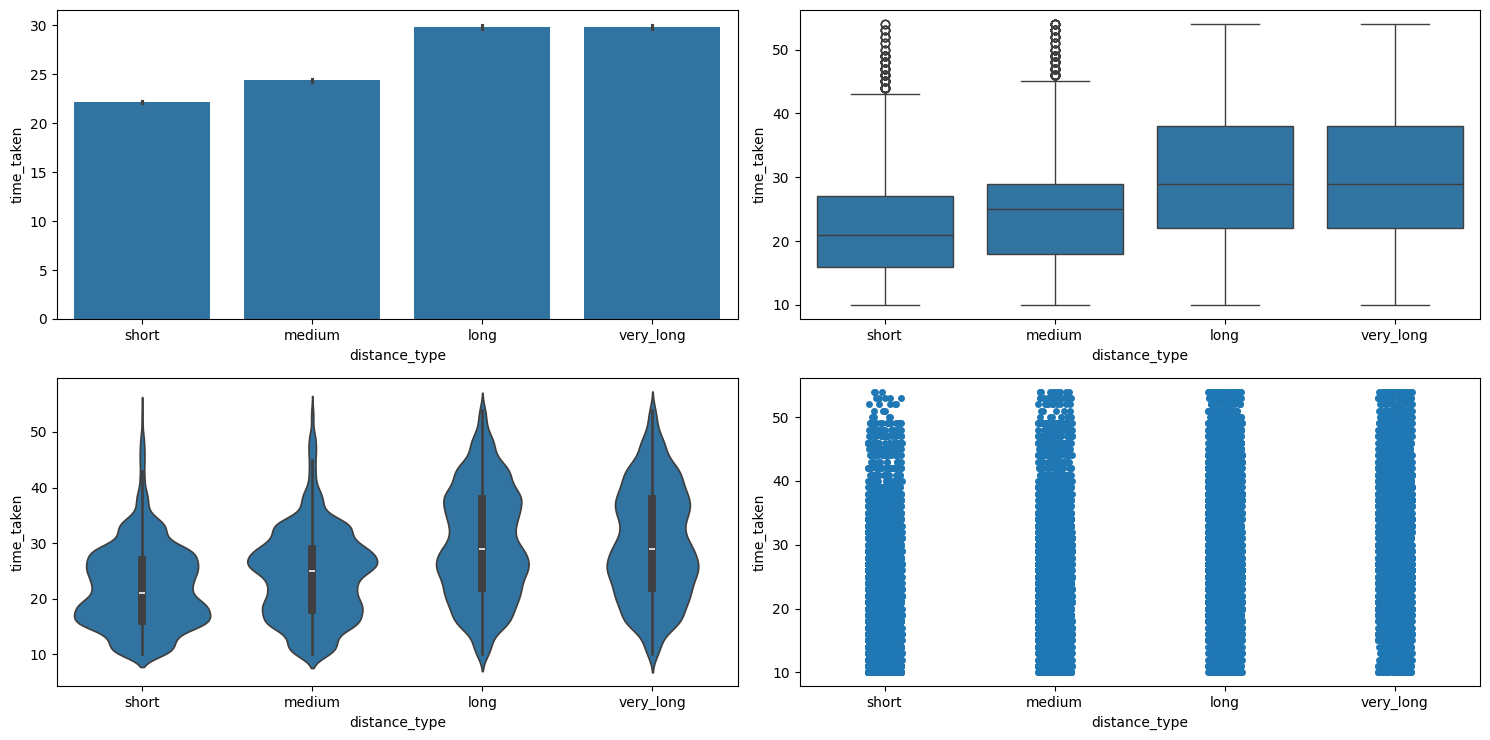

In [126]:
# does distance type affects delivery times

numerical_categorical_analysis(clean_df, "distance_type", "time_taken")

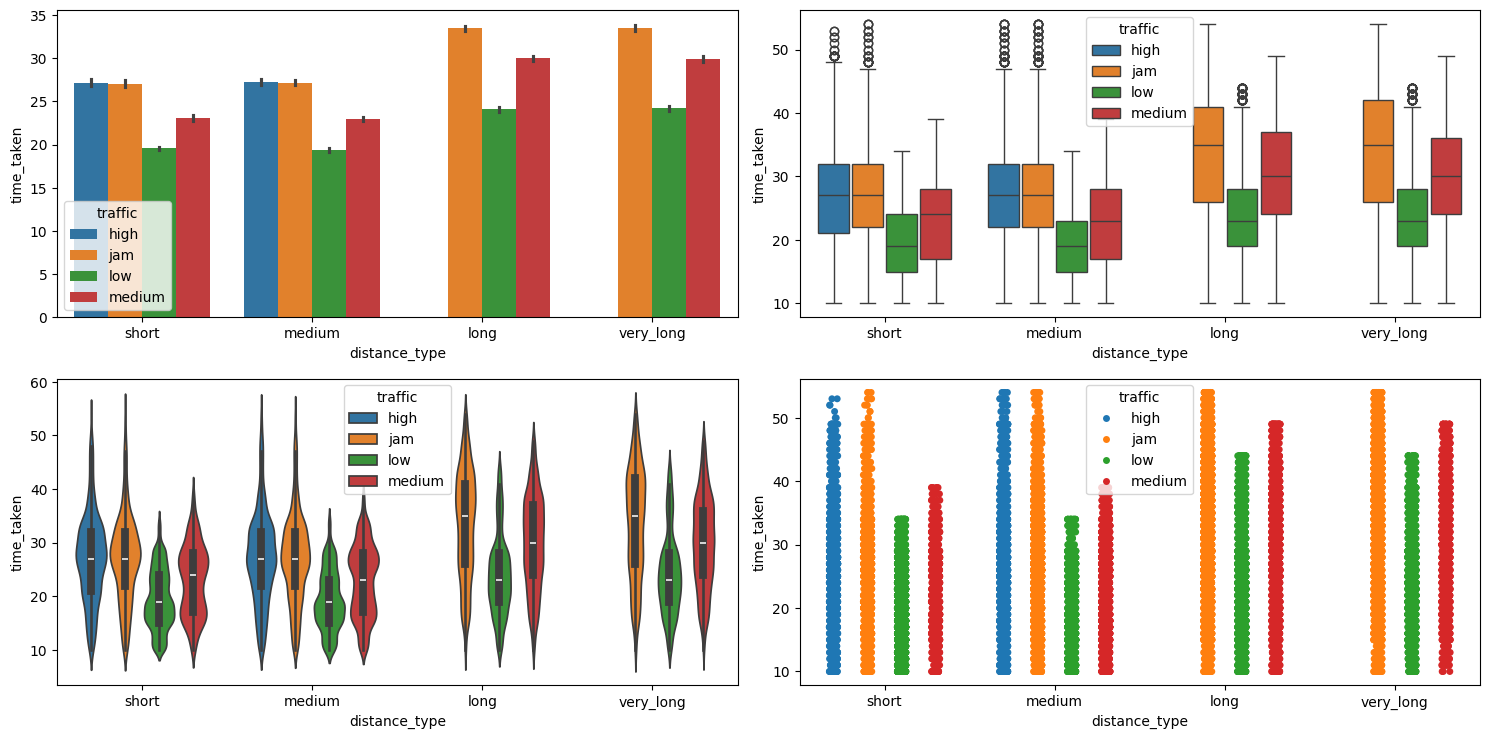

In [127]:
# delivery times based on distance and traffic

multivariate_analysis(clean_df, "time_taken", "distance_type", "traffic")